# **Forecasting S&P BSE SENSEX and S&P-500 Indices Using Autoregressive Integrated Moving Average (ARIMA) Model and Prophet Library.**

In [ ]:
import os
import sys
from google.colab import drive
drive.mount("/content/gdrive")

ROOT_DIR = os.path.abspath("gdrive/MyDrive/Time_Series_Analysis_And_Forecasting/Project/")
DATA_ROOT_DIR = os.path.abspath("gdrive/MyDrive/Time_Series_Analysis_And_Forecasting/Project/Datasets")
S_P_500_DATA_PATH = os.path.join(DATA_ROOT_DIR, 'S&P-500-Price-Action-Historical-Prices-Dataset.csv')

Mounted at /content/gdrive


In [ ]:
!python3 -m pip install quandl
!python3 -m pip install yfinance
!python3 -m pip install investpy
!python3 -m pip uninstall statsmodels -y
!python3 -m pip install pmdarima

     |████████████████████████████████| 6.3MB 3.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=364999912899b09cd15eebd84738b17d07719ef8a60b5711e52e059643740c9b
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 4.4MB 2.9MB/s 
     |████████████████████████████████| 245kB 38.8MB/s 
     |████████████████████████████████| 512kB 35.2MB/s 
  Created wheel for investpy: filename=investpy-1.0.6-cp37-none-any.whl size=4485151 sha256=67289a91d7c04693094e7b5c0ca11618f63335549b11ffb1d184f594850364be
  Stored in directory: /root/.cache/pip/wheels/13/5f/65/a9e30255faec3c0b7dd11b40fa1042c61c5b0cfbbb9797c474
Successfully built investpy
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      

In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
import quandl
with open(os.path.join(ROOT_DIR, 'Quandle-API-KEY.txt')) as api_key:
    quandl.ApiConfig.api_key = api_key.read().strip()
import yfinance as yf
import investpy as ipy

# Data Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import missingno as msno
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Libraries for doing Time Series Analysis
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.graphics.tsaplots as tplt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.model_selection import train_test_split as tts
from pmdarima.arima import auto_arima
import fbprophet as fbp
from fbprophet import Prophet

from scipy.stats import jarque_bera
from sklearn.metrics import *

In [ ]:
print(f"Version of Numpy: {np.__version__}.")
print(f"Version of Pandas: {pd.__version__}.")
print(f"Versios of statsmodels: {sm.__version__}.")
print(f"Version of pmdarima: {pm.__version__}.")
print(f"Version of Fbprophet: {fbp.__version__}.")

Version of Numpy: 1.19.5.
Version of Pandas: 1.1.5.
Versios of statsmodels: 0.12.2.
Version of pmdarima: 1.8.2.
Version of Fbprophet: 0.7.1.


In [ ]:
!ls -h -all $ROOT_DIR

total 11M
-rw------- 1 root root 7.6M May 16 16:42 'BLENP2DSC20038-Suraj-Sharma-TSA-Project (1).ipynb'
-rw------- 1 root root 2.6M May 16 20:30  BLENP2DSC20038-Suraj-Sharma-TSA-Project.ipynb
drwx------ 2 root root 4.0K May 16 17:22  Datasets
-rw------- 1 root root   21 Nov 21  2020  Quandle-API-KEY.txt
-rw------- 1 root root  693 Mar 20 16:23  Reference-Links.txt
drwx------ 2 root root 4.0K May 16 17:22  Reference-Research-Papers
-rw------- 1 root root   25 May 16 17:43  requirements.txt
drwx------ 2 root root 4.0K May 16 17:22  Research-Papers
-rw------- 1 root root 100K Feb 14 17:53  Wall-Street-1.jpg
-rw------- 1 root root  40K Dec 11 10:19  Wall-Street-2.jpeg


In [ ]:
rangeselector_properties = {'buttons': [dict(count = 1, label = '1M', step = 'month', stepmode = 'backward'),
                                      dict(count = 6, label = '6M', step = 'month', stepmode = 'backward'),
                                      dict(count = 1, label = 'YTD', step = 'year', stepmode = 'backward'),
                                      dict(count = 5, label = '5Y', step = 'year', stepmode = 'backward'),
                                      dict(label = 'MAX', step = 'all')]
                           }

#### Hypothesis Test for Normal Distribution of the Data i.e. Jarque Bera Method
* Jarque Bera is a test statistic which allows you to check whether the given data has any other distribution or not on the basis of whether sample data have the skewness and kurtosis matching a normal distribution. 
* As it is statistical test means it will have a Null Hypothesis($H_{0}$) and Alternative Hypothesis ($H_{A}$).  
    $H_{0}$: Given data is normally distributed.  
    $H_{A}$: Given data follows a different distribution.  
* Test Statistic for this test is calculated as follows:  
    $JB = n \times (\frac{S^{2}}{6} + \frac{(K - 3)^{2}}{24})$ where $n = $ Degrees of Freedom, $S = $ Skewness of the data and $K = $ Kurtosis of the data.  
    If the test statistic is always nonnegative or if it is far from zero, it signals that the data do not have a normal distribution.
* If we have enought evidence to support $H_{A}$ i.e. if $\text{p-value} < 0.05$ then we can reject $H_{0}$ otherwise our assumption about the normal distribution of the data still holds i.e. Failed to reject $H_{0}$.  

**References:**  
1. https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test  
2. https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.jarque_bera.html  

In [ ]:
def compute_descriptive_stats(*col_names, timeseries_data: pd.DataFrame) -> pd.DataFrame:
    for col_name in col_names:
        if col_name not in timeseries_data.columns:
            raise Exception(f"Invalid Column Name: {col_name}")
    row_indexes = ['Mean', 'Median', 'Min', 'Max', 'Std. Dev.', 'Skewness', 'Kurtosis']
    operations = ['mean()', 'median()', 'min()', 'max()', 'std()', 'skew()', 'kurtosis()']
    descriptive_stats_df = pd.DataFrame(columns = col_names, index = row_indexes)
    for curr_index, operation in zip(row_indexes, operations):
        curr_result = []
        for col_name in col_names:
            curr_result.append(eval(f"timeseries_data['{col_name}'].{operation}"))
        descriptive_stats_df.loc[curr_index] = curr_result
    descriptive_stats_df.loc['Jarque-Bera'] = [jarque_bera(timeseries_data[col_name]) for col_name in col_names]
    descriptive_stats_df.loc['Observations'] = [timeseries_data.shape[0]] * len(col_names)
    return descriptive_stats_df

In [ ]:
def perform_stationarity_test(timeseries_data: pd.DataFrame, feature_name: str, plot_title: str, legend_title: str) -> pd.DataFrame:
    timeseries_data_sma_50 = timeseries_data[[feature_name]].rolling(50).mean()
    timeseries_data_std_50 = timeseries_data[[feature_name]].rolling(50).std()
    fig, ax = plt.subplots(1, figsize = (20, 7))
    fig.suptitle(plot_title, fontsize = 16, fontdict = dict(weight = 'bold'))
    sns.lineplot(x = timeseries_data.date, 
                 y = timeseries_data[feature_name], 
                 color = 'blue', 
                 label = 'Original', 
                 ax = ax)
    sns.lineplot(x = timeseries_data.date, 
                 y = timeseries_data_sma_50[feature_name], 
                 color = 'red', 
                 label = 'SMA-50', 
                 linewidth = 3, 
                 ax = ax)
    sns.lineplot(x = timeseries_data.date, 
                 y = timeseries_data_std_50[feature_name], 
                 color = 'black', 
                 label = 'STD-50', 
                 linewidth = 2.5, 
                 ax = ax)
    ax.legend(loc = 'best')
    ax.grid(True, alpha = 0.3)
    ax.set_xlabel("Year", fontsize = 14)
    ax.set_ylabel("Close", fontsize = 14)
    ax.tick_params(which = 'major', labelsize = 14)
    ax.legend(title = legend_title)
    sns.despine()
    
    adf_result = adfuller(timeseries_data[feature_name].values)
    adf_df = pd.DataFrame({'t-statistic': [adf_result[0]],
                              'p-value': [adf_result[1]],
                              'Lags Used': [adf_result[2]],
                              'Critical-Value (1%)': [adf_result[4]['1%']],
                              'Critical-Value (5%)': [adf_result[4]['5%']],
                              'Critical-Value (10%)': [adf_result[4]['10%']]
                             })
    return adf_df

In [ ]:
def separate_trend_seasonal(timeseries_data: pd.DataFrame, col_name: str, plot_title: str, use_model = 'multiplicative', period: int = 12) -> None:
    decompose_result = seasonal_decompose(timeseries_data[col_name], model = use_model, period = period)
    subplot_titles = ["Original", "Trend", "Seasonal", "Residue"]
    subplot_data = [decompose_result.observed, decompose_result.trend, decompose_result.seasonal, decompose_result.resid]
    decompose_fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
    decompose_fig.suptitle(plot_title, fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
    for axis, data, title in zip(axes, subplot_data, subplot_titles):
        sns.lineplot(x = data.index, y = data, ax = axis)
        axis.tick_params(which = 'major', labelsize = 12)
        axis.set_title(title, fontsize = 14)
        axis.set_ylabel("")
    sns.despine()
    decompose_fig.tight_layout()

In [ ]:
def extract_cyclicity(timeseries_data: pd.DataFrame, col_name: str, plot_title: str) -> None:
    hp_smoothing_params = dict(Monthly = 6.25, Annual = 129600)
    cyclicity_monthly, _ = hpfilter(timeseries_data[col_name], lamb = hp_smoothing_params['Monthly'])
    cyclicity_quaterly, _ = hpfilter(timeseries_data[col_name]) # Default value of lamb = 1600 (For Quaterly)
    cyclicity_annual, _ = hpfilter(timeseries_data[col_name], lamb = hp_smoothing_params['Annual'])
    
    subplot_titles = ['Original', 'Monthly Cyclicity', 'Quaterly Cyclicity', 'Annual Cyclicity']
    cyclicity_fig, axes = plt.subplots(nrows = 4, figsize = (15, 10))
    cyclicity_fig.suptitle(plot_title, fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
    for axis, data, title in zip(axes, [timeseries_data[col_name], cyclicity_monthly, cyclicity_quaterly, cyclicity_annual], subplot_titles):
        sns.lineplot(x = data.index, y = data, ax = axis)
        axis.set_title(title, fontsize = 14)
        axis.tick_params(which = 'major', labelsize = 12)
    sns.despine()
    cyclicity_fig.tight_layout()

In [ ]:
def lag_plots(timeseries_data, col_name: str, figure_title: str, lags: int = 8) -> None:
    fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 10))
    fig.suptitle(figure_title, fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
    for curr_lag, axis in zip(range(1, 9), axes.flatten()):
        lag_plot(timeseries_data[col_name], lag = curr_lag, ax = axis)
        axis.grid(True, alpha = 0.5)
        axis.set_xlabel("Y(t)", fontsize = 12)
        axis.set_ylabel(f"Y(t + {curr_lag})", fontsize = 12)
        axis.set_title(f"Plot For Lag-{curr_lag}", fontsize = 12)
        axis.tick_params(which = 'major', labelsize = 12)
    fig.tight_layout()
    sns.despine()

In [ ]:
def plot_acf_pacf(timeseries_data: pd.DataFrame, col_name: str, plot_title: str, subplot_title: list, lags: int = 40) -> None:
    fig, axes = plt.subplots(ncols = 3, figsize = (17, 5))
    fig.suptitle(plot_title, fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
    autocorrelation_plot(timeseries_data[col_name], ax = axes[0])
    tplt.plot_acf(timeseries_data[col_name], lags = lags, color = 'r', ax = axes[1])
    for axis in axes[:-1]:
        axis.set_title(subplot_title[0], fontsize = 12)
        axis.set_xlabel(r"Lag Values $(k)$", fontsize = 12)
        axis.set_ylabel(r"Correlation Coefficient ($\rho_{k}$)", fontsize = 12)
        axis.tick_params(which = 'major', labelsize = 12)
    tplt.plot_pacf(timeseries_data[col_name], lags = lags, color = 'r', ax = axes[2])
    axes[2].set_title(subplot_title[1], fontsize = 12)
    axes[2].set_xlabel(r"Lag Values $(k)$", fontsize = 12)
    axes[2].tick_params(which = 'major', labelsize = 12)
    sns.despine()
    fig.tight_layout()

In [ ]:
def timeseries_forecast_using_arima(timeseries_data: pd.DataFrame, forecast_col_name: str, exog_features: list = None, train_data_size: float = 0.90):
    if not isinstance(timeseries_data, pd.DataFrame):
        raise Exception("Given timeseries data is not an instance of Data-Frame class.")
    train_data, validation_data = tts(timeseries_data, train_size = train_data_size)
    auto_arima_model = auto_arima(train_data[forecast_col_name], 
                                  X = train_data[exog_features] if exog_features else None,
                                  m = 7, # For daily forecasts
                                  stepwise = True, 
                                  trace = True, 
                                  error_action = "ignore", 
                                  supress_warnigs = True)
    model_predictions = pd.Series(auto_arima_model.predict(validation_data.shape[0], 
                                                           validation_data[exog_features] if exog_features else None), 
                                  index = validation_data.index)
    return train_data, validation_data, model_predictions, auto_arima_model

In [ ]:
def timeseries_forecast_using_prophet(timeseries_data: pd.DataFrame, exogenous_features, train_data_size: float = 0.90):
    if not isinstance(timeseries_data, pd.DataFrame):
        raise Exception("Given timeseries data is not an instance of Data-Frame class.")
    columns_of_interest = ['date', 'close'] + exogenous_features
    timeseries_data = timeseries_data[columns_of_interest].rename(columns = dict(date = 'ds', close = 'y'))
    train_data, validation_data = tts(timeseries_data, train_size = train_data_size)
    prophet_model = Prophet()
    for efeature in exogenous_features:
        prophet_model.add_regressor(efeature)
    prophet_model.fit(train_data)
    prophet_forecast = prophet_model.predict(validation_data)
    return prophet_model, prophet_forecast

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / y_true)

In [ ]:
def compute_error_metrics(y_true, arima_y_pred, prophet_y_pred):
    metric_df = pd.DataFrame()
    for y_pred in [arima_y_pred, prophet_y_pred]:
        metric_df = metric_df.append([[mean_absolute_error(y_true, y_pred), median_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred), mean_squared_error(y_true, y_pred, squared = False), mean_squared_log_error(y_true, y_pred), r2_score(y_true, y_pred), mean_absolute_percentage_error(y_true, y_pred)]], ignore_index = False)
    metric_df.columns = ['MAE', 'MedAE', 'MSE', 'RMSE', 'MSLE', 'R2-Score', 'MAPE']
    metric_df.index = ['SARIMA', 'Prophet']
    return metric_df

In [ ]:
def plot_predictions(train_data, validation_data, col_name: str = None, start_date = None, end_date = None, model = None, **kwargs) -> None:
    pred_plot = go.Figure()
    pred_plot.add_trace(go.Scatter(x = train_data.index, y = train_data[col_name] if col_name else train_data, name = 'Train'))
    pred_plot.add_trace(go.Scatter(x = validation_data.index, y = validation_data[col_name] if col_name else validation_data, name = 'Validation', line = dict(color = 'orange')))
    if model:
        forecast_dates = pd.date_range(start = start_date, end = end_date, freq = 'D')
        forecast_data = pd.Series(model.predict(len(validation_data)), index = forecast_dates)
    else:
        forecast_data = kwargs['forecast_data']
    pred_plot.add_trace(go.Scatter(x = forecast_data.index, y = forecast_data, name = 'Predictions', line = dict(color = 'red')))
    pred_plot.update_layout(title = kwargs['plot_title'], xaxis_title = 'Date', yaxis_title = 'Close', template = 'gridon')
    pred_plot.show()

In [ ]:
def plot_predictions_matplotlib(train_data, validation_data, arima_predictions, prophet_predictions, **plot_kwargs):
    fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'))
    sns.lineplot(x = train_data.index, y = train_data, ax = axes[0])
    sns.lineplot(x = validation_data.index, y = validation_data, ax = axes[0])
    sns.lineplot(x = validation_data.index, y = arima_predictions, ax = axes[0])
    sns.lineplot(x = validation_data.index, y = prophet_predictions, ax = axes[0])
    sns.lineplot(x = validation_data.index, y = validation_data, ax = axes[1])
    sns.lineplot(x = validation_data.index, y = arima_predictions, ax = axes[1])
    sns.lineplot(x = validation_data.index, y = prophet_predictions, ax = axes[1])
    for axis in axes:
        axis.set_xlabel("Date", fontsize = 12)
        axis.set_ylabel("Close", fontsize = 12)
        axis.tick_params(which = 'major', labelsize = 12)
    axes[0].legend(['Train', 'Validation', 'SARIMAX Predictions', 'Prophet Predictions'])
    axes[1].legend(['Validation', 'SARIMAX Predictions', 'Prophet Predictions'])
    sns.despine()

In [ ]:
sensex_df = quandl.get('BSE/SENSEX', start_date = '2000-01-01', end_date = '2020-12-31').dropna().reset_index()
sensex_df.columns = [col_name.lower() for col_name in sensex_df.columns]
sensex_df['first_diff'] = sensex_df.close.diff().fillna(0.0)
sensex_df['pc_change'] = (100 * sensex_df.close.pct_change()).fillna(0.0)
sensex_df["year"] = sensex_df.date.dt.year.astype(np.int32)
sensex_df['month'] = sensex_df.date.dt.month.astype(np.int8)
sensex_df['day_of_week'] = sensex_df.date.dt.dayofweek.astype(np.int8)
sensex_df['day'] = sensex_df.date.dt.day.astype(np.int8)

In [ ]:
lag_features = ['high', 'low']
window_sizes = [3, 7, 30, 50, 100, 200]
for feature in lag_features:
    for window_size in window_sizes:
        sensex_df[f"{feature}_mean_lag_{window_size}"] = sensex_df[feature].rolling(window = window_size).mean().astype(np.float32)
        sensex_df[f"{feature}_std_dev_lag_{window_size}"] = sensex_df[feature].rolling(window = window_size).std().astype(np.float32)
exogenous_features = sensex_df.columns[11:].tolist()
for curr_col in exogenous_features:
    sensex_df[curr_col].fillna(sensex_df[curr_col].mean(), inplace = True)

In [ ]:
sensex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5226 non-null   datetime64[ns]
 1   open                  5226 non-null   float64       
 2   high                  5226 non-null   float64       
 3   low                   5226 non-null   float64       
 4   close                 5226 non-null   float64       
 5   first_diff            5226 non-null   float64       
 6   pc_change             5226 non-null   float64       
 7   year                  5226 non-null   int32         
 8   month                 5226 non-null   int8          
 9   day_of_week           5226 non-null   int8          
 10  day                   5226 non-null   int8          
 11  high_mean_lag_3       5226 non-null   float32       
 12  high_std_dev_lag_3    5226 non-null   float32       
 13  high_mean_lag_7   

In [ ]:
sensex_df.describe().T

count          mean  ...           75%           max
open                  5226.0  17950.417813  ...  26830.110000  47789.030000
high                  5226.0  18059.395055  ...  26966.255000  47896.970000
low                   5226.0  17805.990383  ...  26711.110000  47602.120000
close                 5226.0  17930.175538  ...  26806.392500  47751.330000
first_diff            5226.0      8.108729  ...    106.997500   2476.260000
pc_change             5226.0      0.052543  ...      0.758584     17.339334
year                  5226.0   2009.970723  ...   2015.000000   2020.000000
month                 5226.0      6.510333  ...      9.000000     12.000000
day_of_week           5226.0      2.008228  ...      3.000000      6.000000
day                   5226.0     15.797933  ...     23.000000     31.000000
high_mean_lag_3       5226.0  18056.099609  ...  26962.047363  47806.457031
high_std_dev_lag_3    5226.0    125.719299  ...    166.281364   1594.936523
high_mean_lag_7       5226.0  18049.638672  ...  26976.256836  47210.425781
high_std_dev_lag_7    5226.0    202.383636  ...    265.731743   2313.739502
high_mean_lag_30      5226.0  18014.988281  ...  26892.723145  45839.406250
high_std_dev_lag_30   5226.0    440.409790  ...    552.431366   4873.120117
high_mean_lag_50      5226.0  17988.324219  ...  26901.487305  44174.097656
high_std_dev_lag_50   5226.0    584.263062  ...    713.358505   5095.349609
high_mean_lag_100     5226.0  17936.888672  ...  27044.015137  41652.351562
high_std_dev_lag_100  5226.0    854.835938  ...   1002.995331   5012.563965
high_mean_lag_200     5226.0  17871.224609  ...  26425.993652  39715.410156
high_std_dev_lag_200  5226.0   1212.029053  ...   1462.193481   4976.264648
low_mean_lag_3        5226.0  17802.689453  ...  26701.968262  47440.792969
low_std_dev_lag_3     5226.0    139.779343  ...    183.677113   2938.069824
low_mean_lag_7        5226.0  17796.251953  ...  26681.551270  46717.277344
low_std_dev_lag_7     5226.0    222.215851  ...    288.895355   3213.523682
low_mean_lag_30       5226.0  17762.144531  ...  26608.058105  45284.472656
low_std_dev_lag_30    5226.0    465.277374  ...    578.796661   5652.580566
low_mean_lag_50       5226.0  17735.871094  ...  26608.445801  43622.789062
low_std_dev_lag_50    5226.0    609.849609  ...    749.449310   5740.935547
low_mean_lag_100      5226.0  17685.582031  ...  26749.099609  41130.054688
low_std_dev_lag_100   5226.0    878.096924  ...   1024.140717   5438.086914
low_mean_lag_200      5226.0  17621.919922  ...  26119.987793  39260.460938
low_std_dev_lag_200   5226.0   1228.840210  ...   1481.799896   5191.945312

[34 rows x 8 columns]

In [ ]:
sensex_descriptive_stats_df = compute_descriptive_stats('close', 'pc_change', timeseries_data = sensex_df)
sensex_descriptive_stats_df

close                 pc_change
Mean                           17930.2                 0.0525427
Median                         17222.6                 0.0952336
Min                            2600.12                  -13.1526
Max                            47751.3                   17.3393
Std. Dev.                      11379.9                    1.4641
Skewness                      0.401981                  -0.13972
Kurtosis                     -0.875044                   9.65161
Jarque-Bera   (307.5131296672058, 0.0)  (20257.59182146547, 0.0)
Observations                      5226                      5226

In [ ]:
print(f"Total Missing Values: {sensex_df.isnull().sum().sum()}.")

Total Missing Values: 0.


In [ ]:
sensex_df.head()

date     open  ...  low_mean_lag_200  low_std_dev_lag_200
0 2000-01-03  5209.54  ...      17621.925781          1228.840576
1 2000-01-04  5533.98  ...      17621.925781          1228.840576
2 2000-01-05  5265.09  ...      17621.925781          1228.840576
3 2000-01-06  5424.21  ...      17621.925781          1228.840576
4 2000-01-07  5358.28  ...      17621.925781          1228.840576

[5 rows x 35 columns]

In [ ]:
sensex_df.isnull().sum()

date                    0
open                    0
high                    0
low                     0
close                   0
first_diff              0
pc_change               0
year                    0
month                   0
day_of_week             0
day                     0
high_mean_lag_3         0
high_std_dev_lag_3      0
high_mean_lag_7         0
high_std_dev_lag_7      0
high_mean_lag_30        0
high_std_dev_lag_30     0
high_mean_lag_50        0
high_std_dev_lag_50     0
high_mean_lag_100       0
high_std_dev_lag_100    0
high_mean_lag_200       0
high_std_dev_lag_200    0
low_mean_lag_3          0
low_std_dev_lag_3       0
low_mean_lag_7          0
low_std_dev_lag_7       0
low_mean_lag_30         0
low_std_dev_lag_30      0
low_mean_lag_50         0
low_std_dev_lag_50      0
low_mean_lag_100        0
low_std_dev_lag_100     0
low_mean_lag_200        0
low_std_dev_lag_200     0
dtype: int64

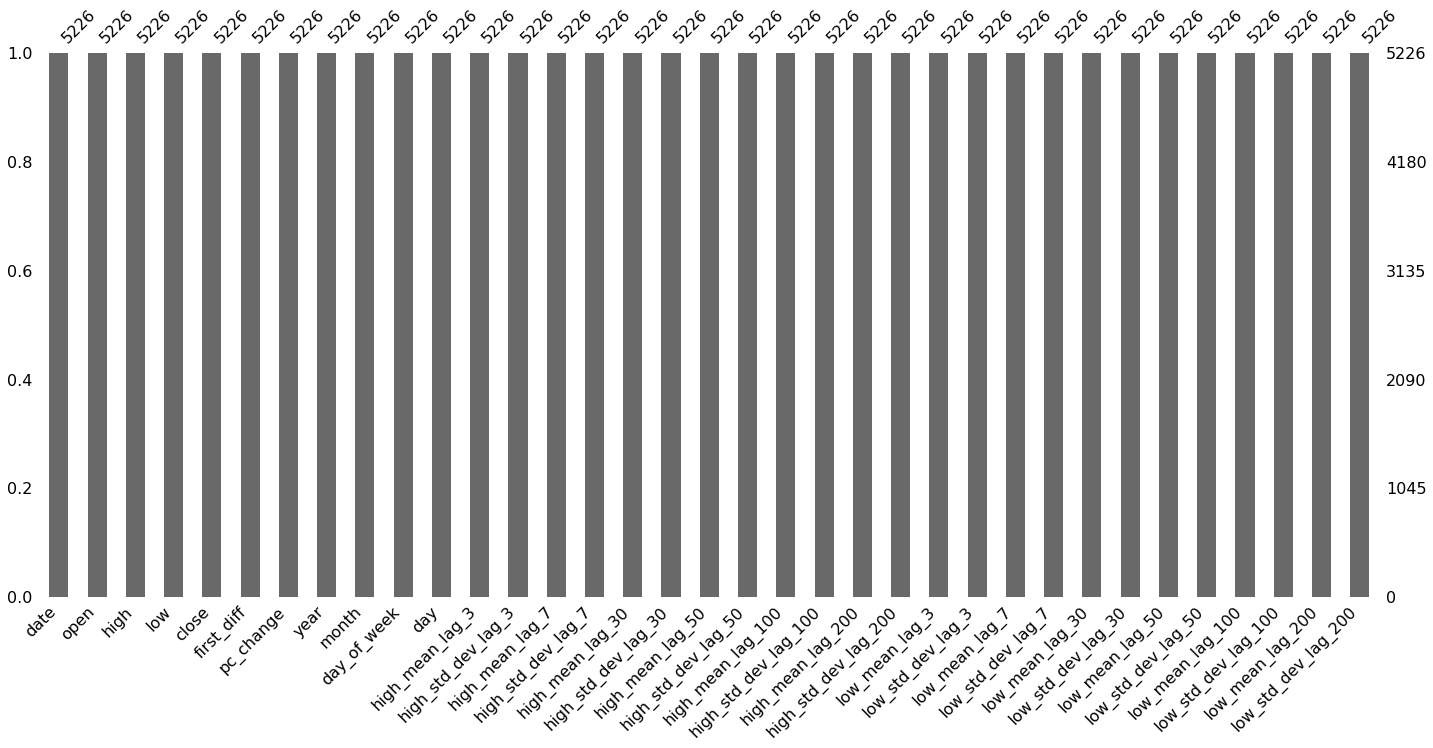

In [ ]:
msno.bar(sensex_df)

In [ ]:
india_vix_df = ipy.get_index_historical_data(index = "India VIX", 
                                             country = "India", 
                                             from_date = "04/03/2008", 
                                             to_date = "31/12/2020").reset_index().drop(["Volume", "Currency"], axis = 1)
india_vix_df.columns = [col_name.lower() for col_name in india_vix_df.columns]
india_vix_df['first_diff'] = india_vix_df.close.diff().fillna(0.0)
india_vix_df['pc_change'] = (100 * india_vix_df.close.pct_change()).fillna(0.0)
india_vix_df['month'] = india_vix_df.date.dt.month
india_vix_df['year'] = india_vix_df.date.dt.year

In [ ]:
india_vix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3171 non-null   datetime64[ns]
 1   open        3171 non-null   float64       
 2   high        3171 non-null   float64       
 3   low         3171 non-null   float64       
 4   close       3171 non-null   float64       
 5   first_diff  3171 non-null   float64       
 6   pc_change   3171 non-null   float64       
 7   month       3171 non-null   int64         
 8   year        3171 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 223.1 KB


In [ ]:
india_vix_df.describe().T

count         mean  ...          75%         max
open        3171.0    21.570787  ...    24.642500    88.68000
high        3171.0    23.405553  ...    25.903750    92.53000
low         3171.0    19.769315  ...    23.215000    75.97250
close       3171.0    21.569749  ...    24.740000    85.13000
first_diff  3171.0    -0.005356  ...     0.501250    22.85000
pc_change   3171.0     0.166058  ...     2.650422    64.35875
month       3171.0     6.571429  ...     9.500000    12.00000
year        3171.0  2014.087039  ...  2017.000000  2020.00000

[8 rows x 8 columns]

In [ ]:
india_vix_descriptive_stats_df = compute_descriptive_stats('close', 'first_diff', timeseries_data = india_vix_df)
india_vix_descriptive_stats_df

close                 first_diff
Mean                            21.5697                -0.00535635
Median                           18.265                    -0.0425
Min                             10.4475                        -22
Max                               85.13                      22.85
Std. Dev.                       9.94465                    1.95336
Skewness                        2.07967                   0.628188
Kurtosis                        5.45052                    36.9318
Jarque-Bera   (6193.7189784912325, 0.0)  (179835.50297279283, 0.0)
Observations                       3171                       3171

In [ ]:
india_vix_df.head()

date   open   high    low  close  first_diff  pc_change  month  year
0 2008-03-04  38.08  51.07  30.59  38.08        0.00   0.000000      3  2008
1 2008-03-05  38.08  38.76  27.95  35.51       -2.57  -6.748950      3  2008
2 2008-03-07  36.95  39.34  27.05  35.20       -0.31  -0.872994      3  2008
3 2008-03-10  25.33  47.95  25.33  32.58       -2.62  -7.443182      3  2008
4 2008-03-11  30.72  37.54  29.75  32.69        0.11   0.337630      3  2008

In [ ]:
print(f"Total Missing Values Count: {india_vix_df.isnull().sum().sum()}.")

Total Missing Values Count: 0.


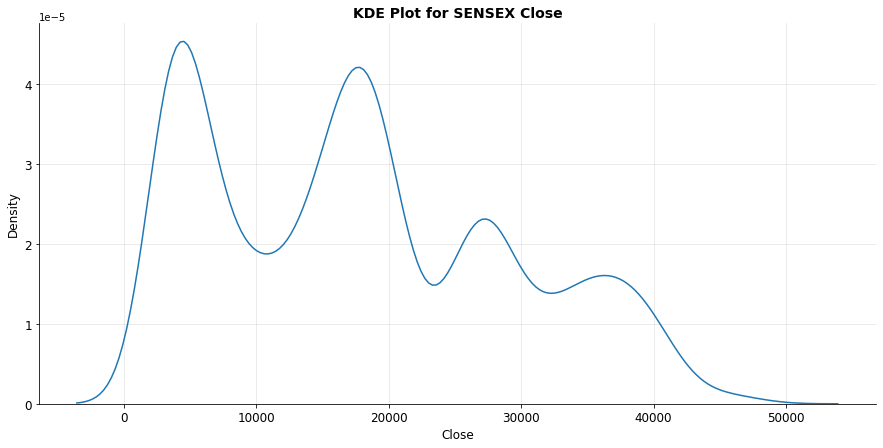

In [ ]:
sensex_line_plot = px.line(sensex_df, 
                           x = 'date', 
                           y = 'close', 
                           labels = dict(date = 'Date', close = 'Close'),
                           title = 'S&P BSE SENSEX (2000-2020)', 
                           template = 'gridon')
sensex_line_plot.update_xaxes(showspikes = True, 
                              rangeselector = rangeselector_properties)
sensex_line_plot.update_yaxes(showspikes = True)
sensex_line_plot.show()

fig, axis = plt.subplots(figsize = (15, 7))
axis.grid(True, alpha = 0.3)
axis.set_title("KDE Plot for SENSEX Close", fontsize = 14, fontdict = dict(weight = 'bold'))
sns.kdeplot(sensex_df.close, ax = axis)
axis.set_xlabel("Close", fontsize = 12)
axis.set_ylabel("Density", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
sns.despine()

In [ ]:
sensex_df_subplots = make_subplots()
for window_size, legend_name in zip((30, 50, 100, 200), ('SMA-30', 'SMA-50', 'SMA-100', 'SMA-200')):
    sensex_df_subplots.add_trace(go.Scatter(x = sensex_df.date, 
                                            y = sensex_df.close.rolling(window_size).mean(), 
                                            name = legend_name, visible = 'legendonly' if legend_name != 'SMA-30' else None), 1, 1)
sensex_df_subplots.add_trace(go.Box(x = sensex_df.year, 
                                    y = sensex_df.close, 
                                    name = 'Yearly-Distribution'), 1, 1)
sensex_df_subplots.update_xaxes(showspikes = True)
sensex_df_subplots.update_layout(title = "S&P BSE SENSEX (2000-2020)", xaxis_title = 'Date', yaxis_title = 'Close', template = 'gridon')
sensex_df_subplots.show()

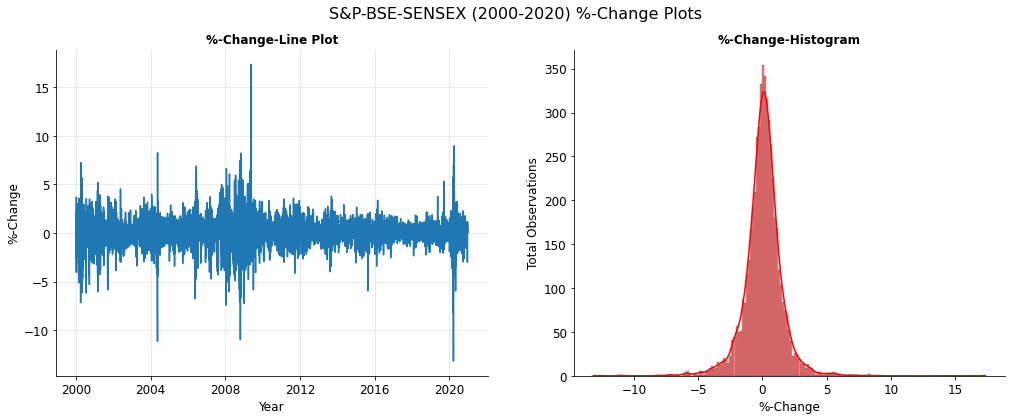

In [ ]:
india_vix_fig = go.Figure()
india_vix_fig.add_trace(go.Scatter(x = india_vix_df.date, 
                                   y = india_vix_df.close,
                                   line = dict(color = 'red', width = 2),
                                   name = 'INDIA-VIX'))
india_vix_fig.add_trace(go.Scatter(x = india_vix_df.date, 
                                   y = india_vix_df.close.rolling(30).mean(),
                                   line = dict(color = 'black'),
                                   name = 'SMA-30'))
india_vix_fig.add_trace(go.Box(x = india_vix_df.year, 
                               y = india_vix_df.close, 
                               name = 'Yearly-Distribution', 
                               marker_color = 'blue'))

india_vix_fig.update_xaxes(showspikes = True, 
                                   rangeselector = rangeselector_properties)
india_vix_fig.update_yaxes(showspikes = True)
india_vix_fig.update_layout(title = "NIFTY INDIA-VIX (2008-2020)", 
                            xaxis_title = "Date", 
                            yaxis_title = "Close",
                            template = 'gridon')
india_vix_fig.show()

sensex_pct_change_fig, axes = plt.subplots(ncols = 2, figsize = (17, 6))
sensex_pct_change_fig.suptitle("S&P-BSE-SENSEX (2000-2020) %-Change Plots", 
                               fontsize = 16, 
                               fontdict = dict(weight = 'bold'))
sns.lineplot(x = sensex_df.date, 
             y = sensex_df.pc_change, 
             ax = axes[0])
axes[0].grid(True, alpha = 0.3)
axes[0].set_title("%-Change-Line Plot", 
                  fontsize = 12,
                  fontdict = dict(weight = 'bold'), loc = 'center')
axes[0].set_xlabel("Year", fontsize = 12)
axes[0].set_ylabel("%-Change", fontsize = 12)
axes[0].tick_params(which = 'major', labelsize = 12)

sns.histplot(x = sensex_df.pc_change, 
             kde = True, 
             color = 'red',
             ax = axes[1])
axes[1].set_title("%-Change-Histogram", 
                  fontsize = 12, 
                  fontdict = dict(weight = 'bold'), 
                  loc = 'center')
axes[1].set_xlabel("%-Change", fontsize = 12)
axes[1].set_ylabel("Total Observations", fontsize = 12)
axes[1].tick_params(which = 'major', labelsize = 12)
sns.despine()

### **Augmented Dickey Fuller (ADF) Test To Check Stationarity of the S&P BSE SENSEX Time Series Data**

* Before applying any forecasting technique we need to check the staionarity of the given time series data. For checking the stationarity we are going to use Augmented Dickey Fuller (ADF) Test which is one of unit root test mostly used to check the stationarity of the time series.
* ADF is statistical test i.e. we will have Null Hypothesis ($H_{0}$) and Alternative Hypothesis ($H_{A}$) and according to test-statistic or p-value we either reject $H_{0}$ or fail to reject $H_{0}$.  

**The Hypothesis are as follows:**
* $H_{0}$: There exist a unit root i.e. $\alpha = 1$ for the given time series hence the time series is non-stationary i.e. it has time-dependent structure.
* $H_{A}$: There doesn't exist unit root i.e. $\alpha \neq 1$ for the given time series hence the given time series is stationary i.e. it doesn't have a time-dependent structure.

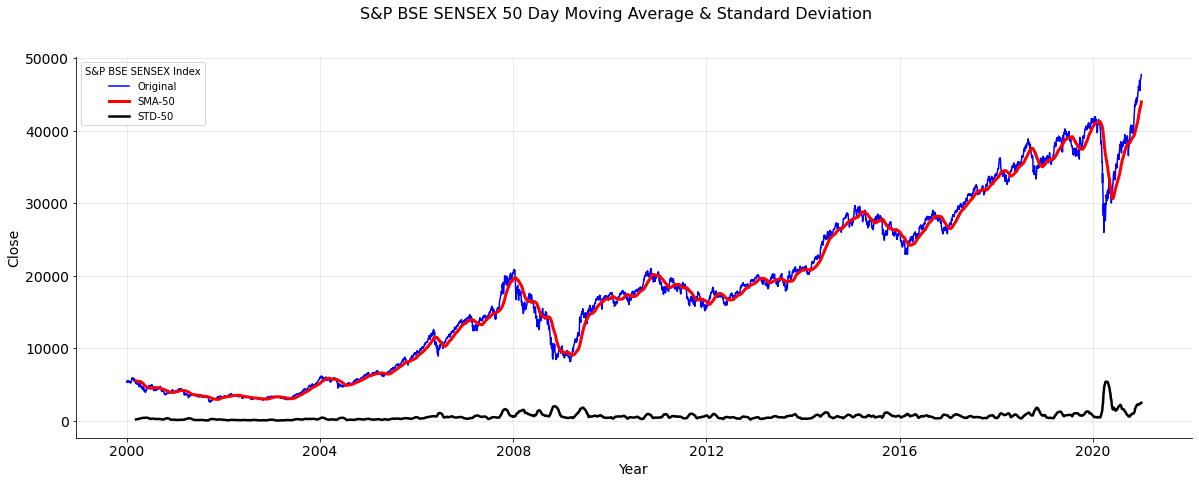

In [ ]:
sensex_adf_df = perform_stationarity_test(sensex_df, 
                                   feature_name = 'close',
                                   plot_title = 'S&P BSE SENSEX 50 Day Moving Average & Standard Deviation',
                                   legend_title = 'S&P BSE SENSEX Index')

#### **Result of ADF Test on Close Value of BSE SENSEX:**
* As $p-value$ obtained i.e. $0.989598 > 0.05(\alpha) \implies$ we fail to reject $H_{0}$.
* Also if we compare our Test Statistic i.e. $0.688133$ obtained with $1\% \; (-3.431032)$, $5\% \; (-2.861841)$ and $10\% \; (-2.56693)$ significance level critical values we infer that:
Test-Statistic $>$ $1\%$, $5\%$ and $10\%$ critical values $\implies$ we fail to reject $H_{0}$.


#### **Conclusion:**
* <em>The given time series data i.e. S&P BSE SENSEX is not stationary as we failed to reject $H_{0}$.</em>

In [ ]:
sensex_adf_df

t-statistic   p-value  ...  Critical-Value (5%)  Critical-Value (10%)
0     0.688133  0.989598  ...            -2.862096             -2.567066

[1 rows x 6 columns]

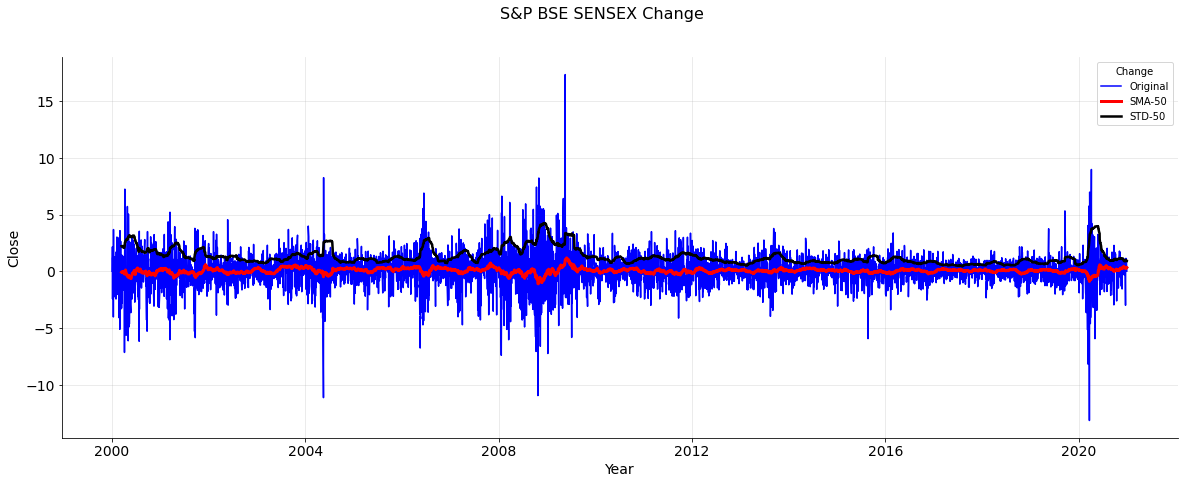

In [ ]:
adf_pct_change_df = perform_stationarity_test(sensex_df, 
                                       'pc_change', 
                                       'S&P BSE SENSEX Change', 
                                       'Change')

#### **Result of ADF Test on the %-Change in the Close value of BSE SENSEX:**
* As $p-value$ obtained i.e. $5.389647 \times 10^{-29} << 0.05 (\alpha) \implies$ we have enough evidence to reject the $H_{0}$.
* Also if we compare our Test Statistic i.e. $-16.080128$ with $1\% \; (-3.431032)$, $5\% \; (-2.861841)$ and $10\% \; (-2.56693)$ significance level critical values we infer that:
Test-Statistic $<$ $1\%$, $5\%$ and $10\%$ significance level critical values $\implies$ we have enough evidence to reject the $H_{0}$.


#### **Conclusion:**
* <em>After performing ADF test on %-Change in Close value of S\&P BSE SENSEX we infer that the given series is stationary, hence we reject $H_{0}$.</em>

In [ ]:
adf_pct_change_df

t-statistic       p-value  ...  Critical-Value (5%)  Critical-Value (10%)
0   -16.080128  5.389647e-29  ...            -2.862095             -2.567066

[1 rows x 6 columns]

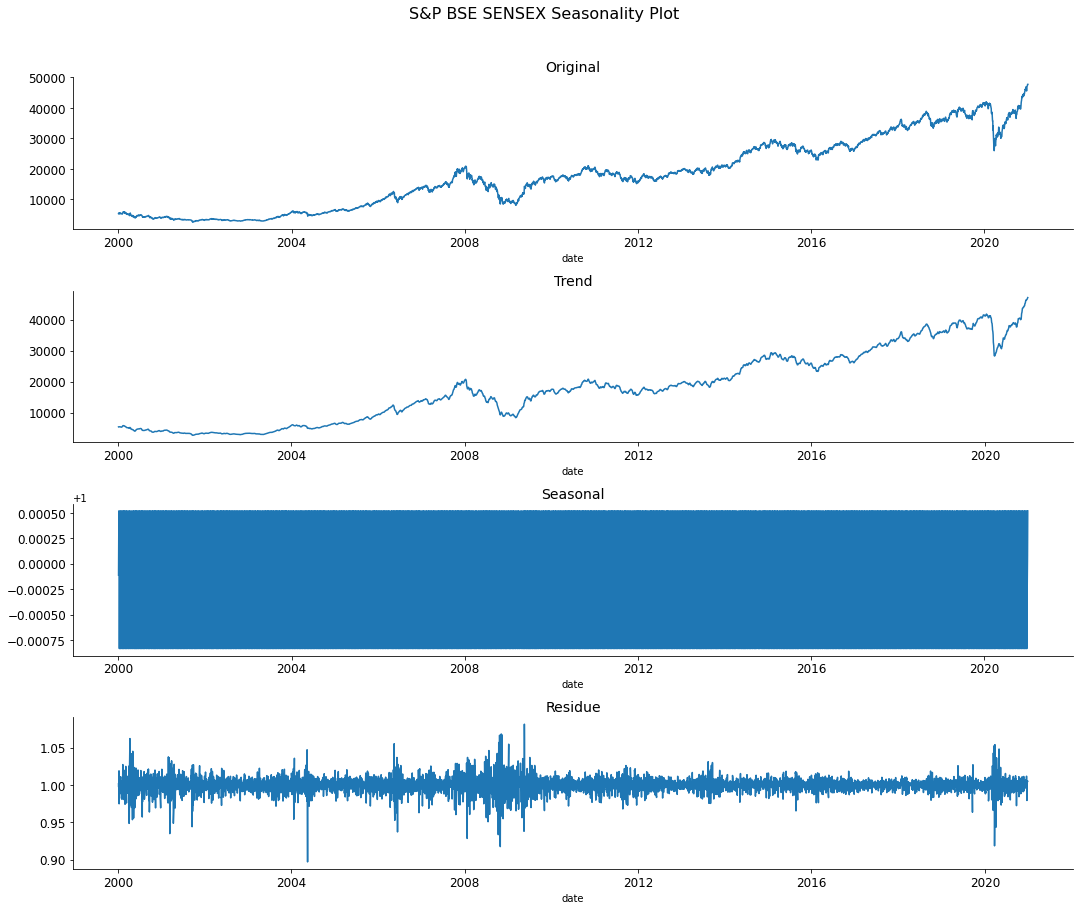

In [ ]:
separate_trend_seasonal(sensex_df.set_index('date'), 'close', 
                        plot_title = "S&P BSE SENSEX Seasonality Plot", period = 7)

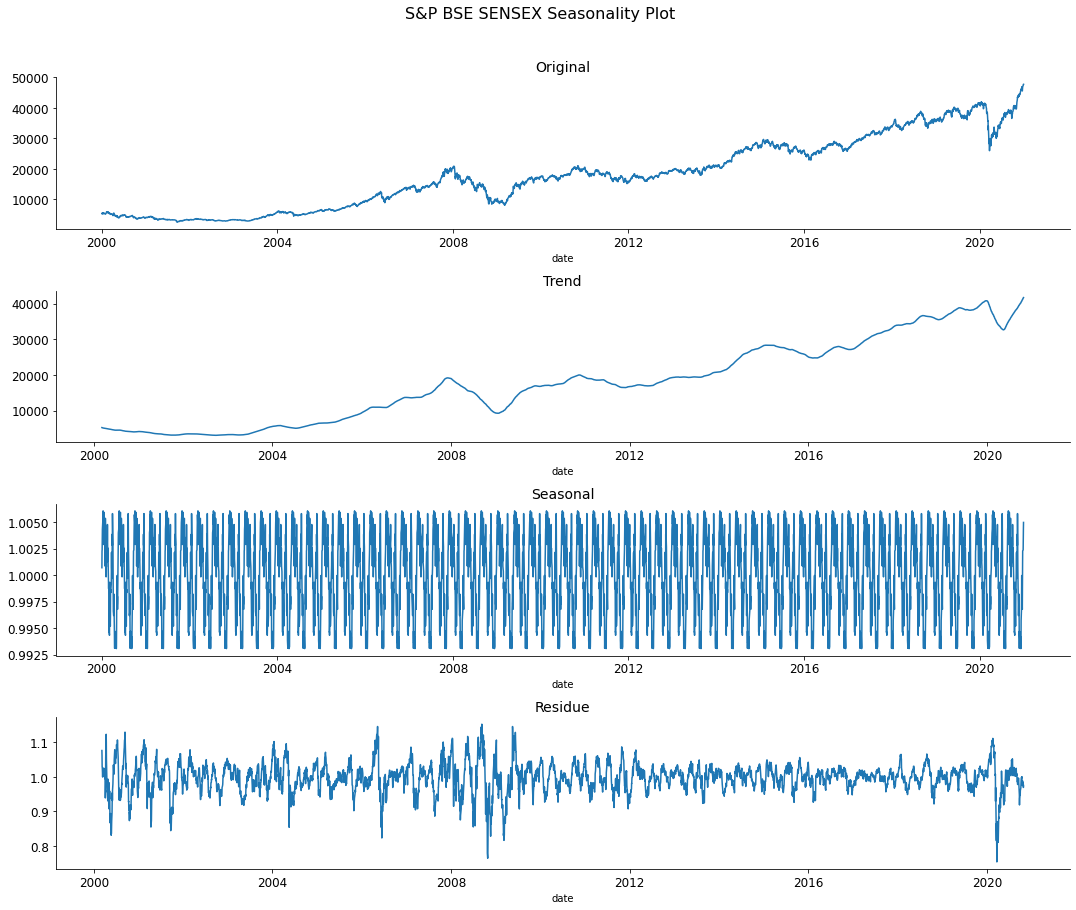

In [ ]:
separate_trend_seasonal(sensex_df.set_index('date'), 'close', 
                        "S&P BSE SENSEX Seasonality Plot", 
                        period = 90)

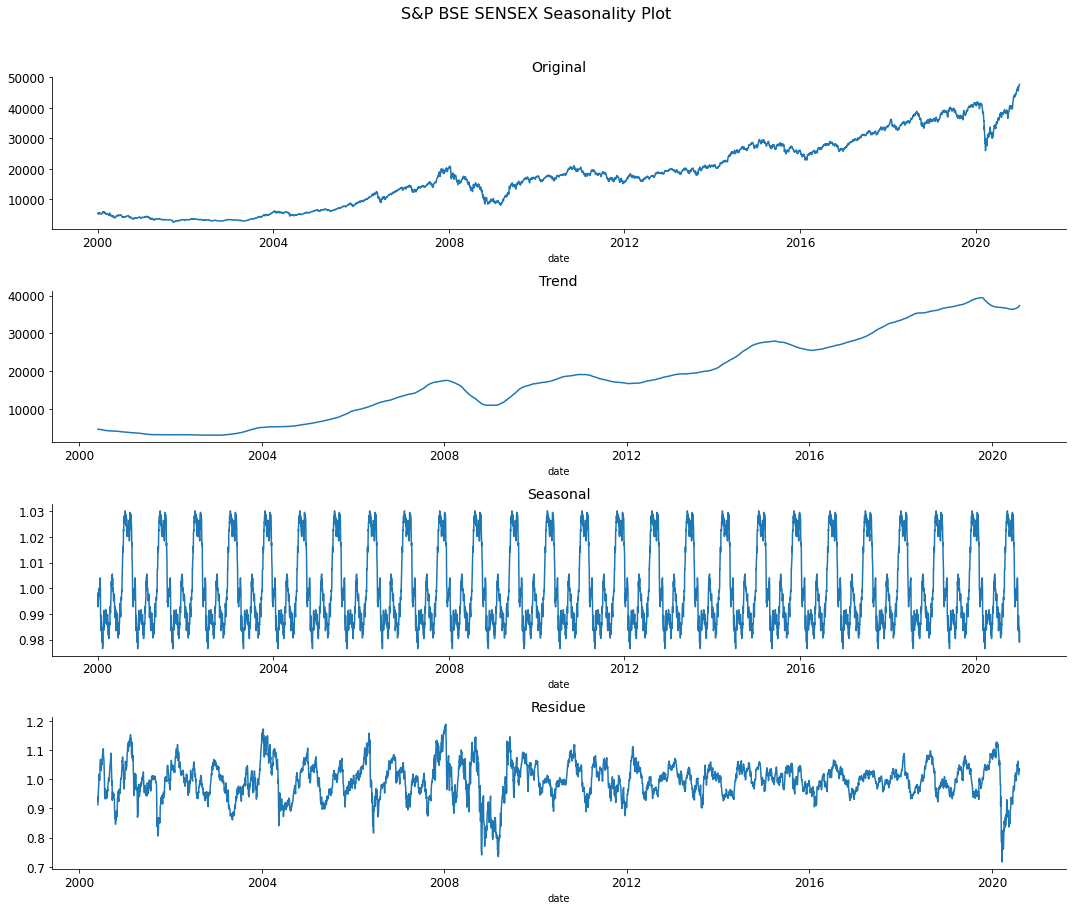

In [ ]:
separate_trend_seasonal(sensex_df.set_index('date'), 'close', 
                        period = 200, 
                        plot_title = "S&P BSE SENSEX Seasonality Plot")

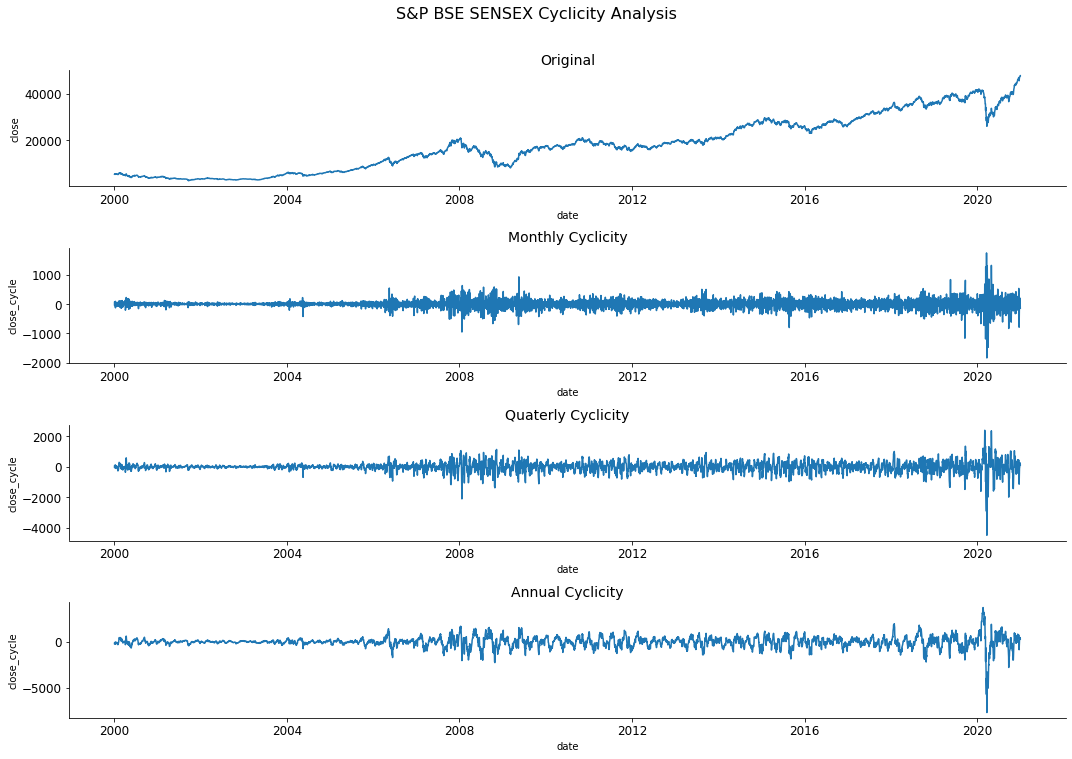

In [ ]:
extract_cyclicity(sensex_df.set_index('date'), 'close', 
                  "S&P BSE SENSEX Cyclicity Analysis")

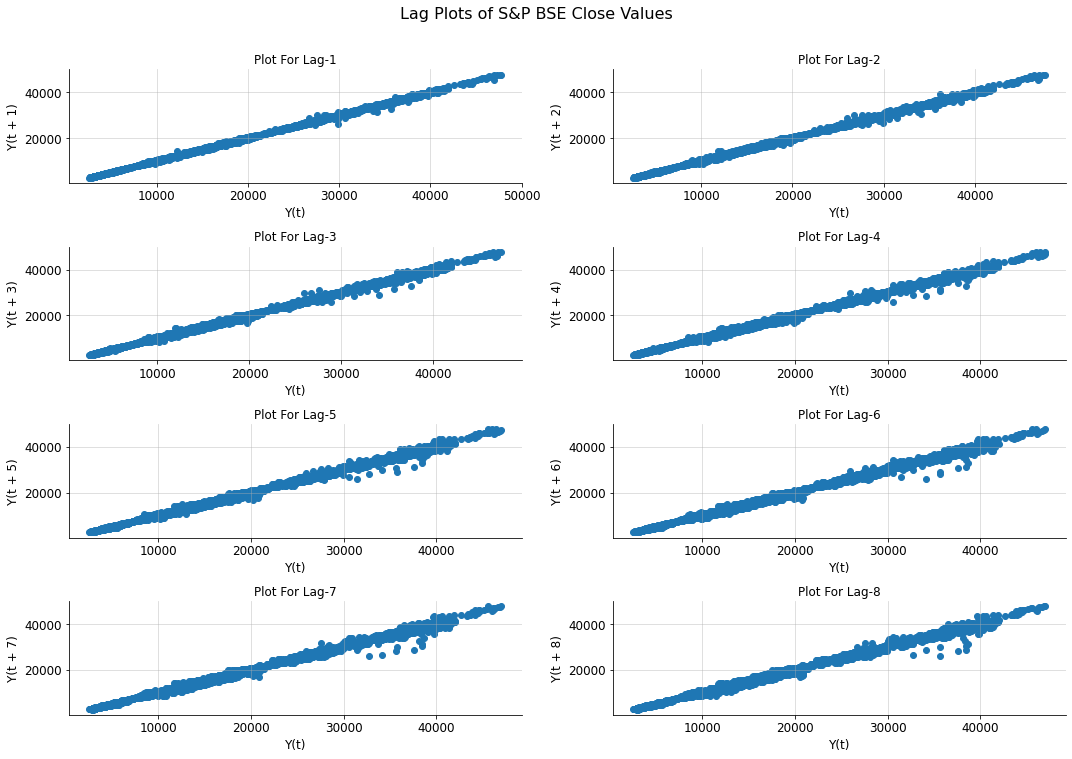

In [ ]:
lag_plots(sensex_df, 'close', 'Lag Plots of S&P BSE Close Values')

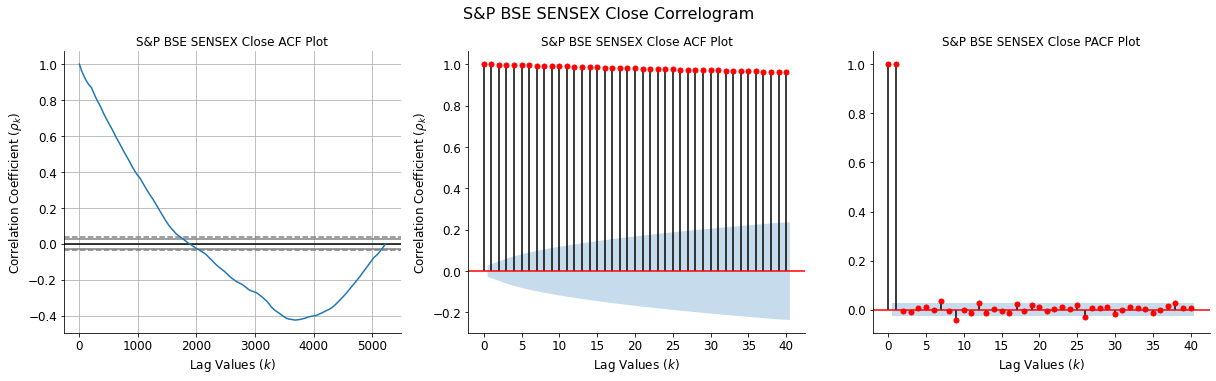

In [ ]:
plot_acf_pacf(sensex_df.set_index('date'), 'close', "S&P BSE SENSEX Close Correlogram",
                 ["S&P BSE SENSEX Close ACF Plot", "S&P BSE SENSEX Close PACF Plot"])

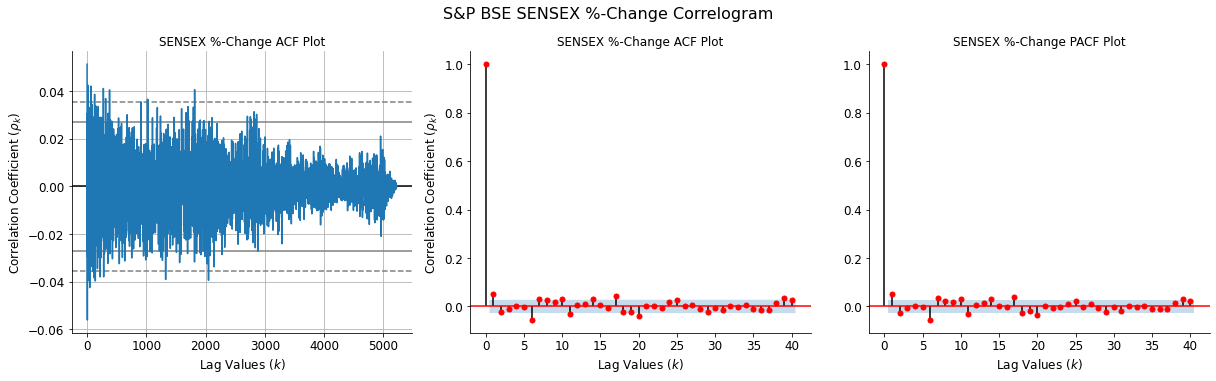

In [ ]:
plot_acf_pacf(sensex_df.set_index('date'), 'pc_change', "S&P BSE SENSEX %-Change Correlogram",
                 ['SENSEX %-Change ACF Plot', 'SENSEX %-Change PACF Plot'])

### Spliting the Data Into Training & Validation Sets.
* Ratio used is `90:10` i.e. `90%` of the data for training and `10%` of the data for validation.

In [ ]:
%%time
sensex_train_data, sensex_validation_data, sensex_predictions, sensex_auto_arima_model = timeseries_forecast_using_arima(timeseries_data = sensex_df.set_index('date'), 
                                                                                                                         forecast_col_name = 'close',
                                                                                                                         exog_features = exogenous_features)

%store sensex_train_data
%store sensex_validation_data
%store sensex_predictions 
%store sensex_auto_arima_model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=66300.235, Time=96.05 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=67521.064, Time=5.88 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=67.01 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=68100.858, Time=74.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=102585.775, Time=1.86 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=66595.465, Time=84.40 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=66201.139, Time=81.71 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=66324.432, Time=46.44 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=65079.644, Time=131.23 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=66059.787, Time=144.86 sec
 ARIMA(1,0,2)(2,0,0)[7] intercept   : AIC=66159.509, Time=132.21 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=63798.806, Time=134.64 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=65989.971, Time=76.58 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=64092.022, Time=134.59 sec
 ARIMA(

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Stored 'sensex_train_data' (DataFrame)
Stored 'sensex_validation_data' (DataFrame)
Stored 'sensex_predictions' (Series)
Stored 'sensex_auto_arima_model' (ARIMA)
CPU times: user 35min 44s, sys: 38min 12s, total: 1h 13min 57s
Wall time: 38min 23s


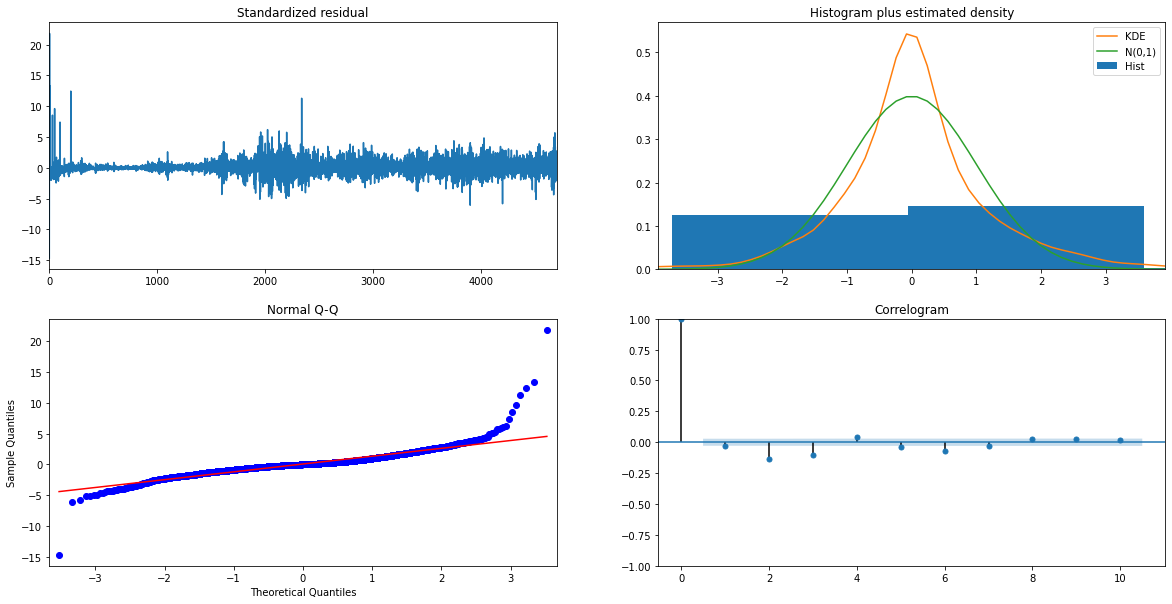

In [ ]:
sensex_diagnostics_plot = sensex_auto_arima_model.plot_diagnostics(figsize = (20, 10))

In [ ]:
sensex_auto_arima_summary = sensex_auto_arima_model.summary()
sensex_auto_arima_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4703
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 7)   Log Likelihood              -31868.403
Date:                            Wed, 26 May 2021   AIC                          63798.806
Time:                                    11:42:24   BIC                          63998.940
Sample:                                         0   HQIC                         63869.168
                                           - 4703                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                3.8404      7.523      0.510      0.610     -10.905      18.585
high_mean_lag_3         -0.5715      0.031    -18.537      0.000      -0.632      -0.511
high_std_dev_lag_3       0.4809      0.020     24.491      0.000       0.442       0.519
high_mean_lag_7          0.4994      0.074      6.738      0.000       0.354       0.645
high_std_dev_lag_7       0.2462      0.051      4.856      0.000       0.147       0.346
high_mean_lag_30         0.2050      0.316      0.648      0.517      -0.415       0.825
high_std_dev_lag_30      0.1474      0.222      0.665      0.506      -0.287       0.582
high_mean_lag_50         0.2293      0.627      0.366      0.715      -1.000       1.459
high_std_dev_lag_50      0.2476      0.404      0.613      0.540      -0.544       1.039
high_mean_lag_100       -0.1617      1.162     -0.139      0.889      -2.439       2.115
high_std_dev_lag_100    -0.1698      0.689     -0.246      0.805      -1.521       1.181
high_mean_lag_200        0.1162      1.616      0.072      0.943      -3.051       3.284
high_std_dev_lag_200    -0.0135      1.162     -0.012      0.991      -2.291       2.263
low_mean_lag_3           0.8718      0.031     27.965      0.000       0.811       0.933
low_std_dev_lag_3       -0.4504      0.017    -27.006      0.000      -0.483      -0.418
low_mean_lag_7          -0.3129      0.074     -4.200      0.000      -0.459      -0.167
low_std_dev_lag_7       -0.3106      0.050     -6.156      0.000      -0.409      -0.212
low_mean_lag_30         -0.0827      0.319     -0.259      0.795      -0.708       0.543
low_std_dev_lag_30      -0.1789      0.214     -0.836      0.403      -0.598       0.241
low_mean_lag_50         -0.0898      0.630     -0.143      0.887      -1.325       1.145
low_std_dev_lag_50      -0.3206      0.407     -0.787      0.431      -1.119       0.478
low_mean_lag_100         0.2514      1.168      0.215      0.830      -2.037       2.540
low_std_dev_lag_100      0.2205      0.708      0.312      0.755      -1.166       1.607
low_mean_lag_200         0.0212      1.625      0.013      0.990      -3.164       3.206
low_std_dev_lag_200      0.0084      1.177      0.007      0.994      -2.299       2.316
ar.L1                    0.3229      0.540      0.598      0.550      -0.736       1.382
ar.L2                    0.6453      0.530      1.217      0.224      -0.394       1.685
ma.L1                    0.6645      0.536      1.239      0.215      -0.386       1.715
ar.S.L7                  0.0093      0.008      1.184      0.236      -0.006       0.025
ar.S.L14                 0.0268      0.007      3.575      0.000       0.012       0.041
sigma2                2.426e+04    215.364    112.635      0.000    2.38e+04    2.47e+04
===================================================================================
Ljung-Box (L1) (Q):    

In [ ]:
plot_predictions(sensex_train_data['close'], 
                 sensex_validation_data['close'], 
                 forecast_data = sensex_predictions, 
                 plot_title = "SARIMA Predictions (S&P BSE SENSEX)")

### Forecasting S&P BSE SENSEX Using Prophet

In [ ]:
sensex_prophet_model, sensex_prophet_predictions = timeseries_forecast_using_prophet(sensex_df, exogenous_features)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


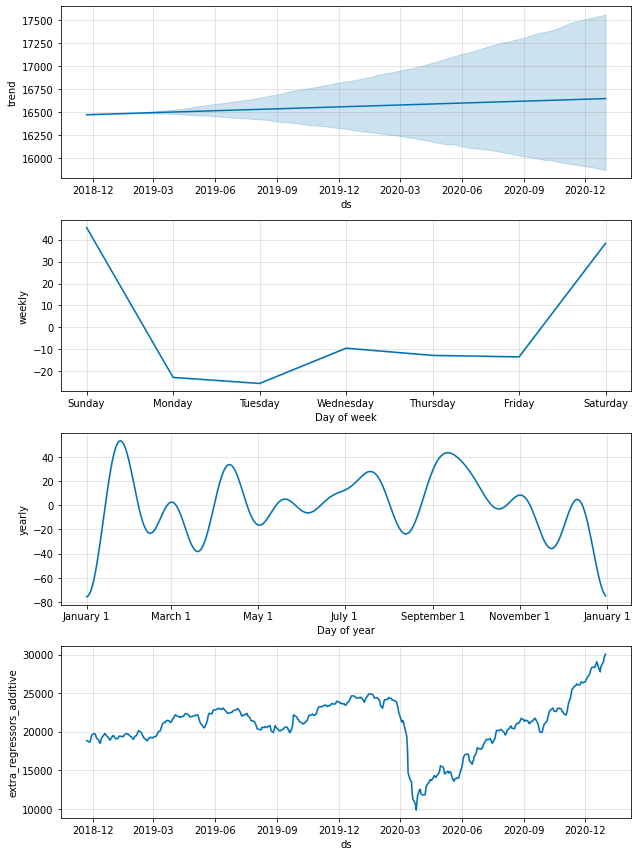

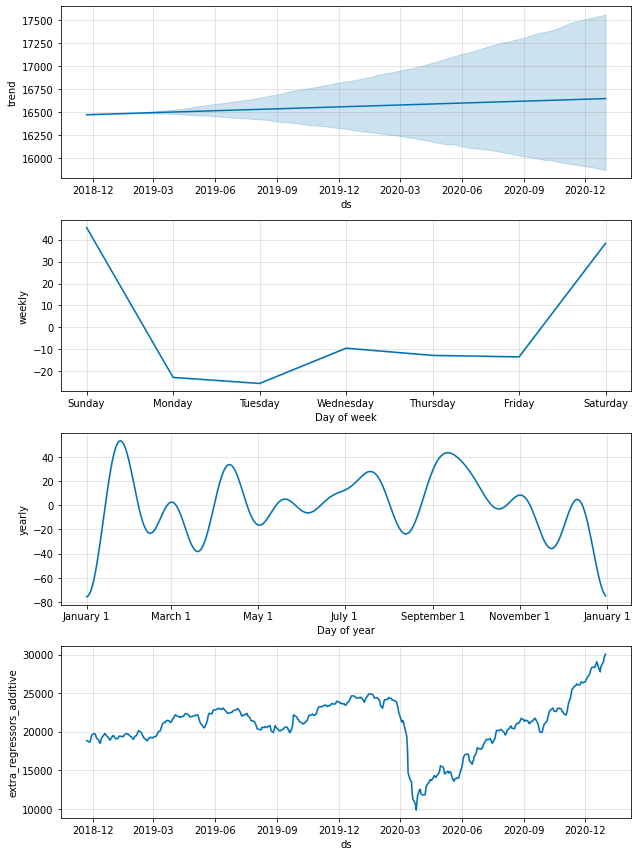

In [ ]:
sensex_prophet_model.plot_components(sensex_prophet_predictions)

In [ ]:
plot_predictions(sensex_train_data, 
                 sensex_validation_data, 
                 col_name = 'close', 
                 forecast_data = sensex_prophet_predictions.set_index('ds').yhat, 
                 plot_title = 'Prophet Predictions (S&P BSE SENSEX)')

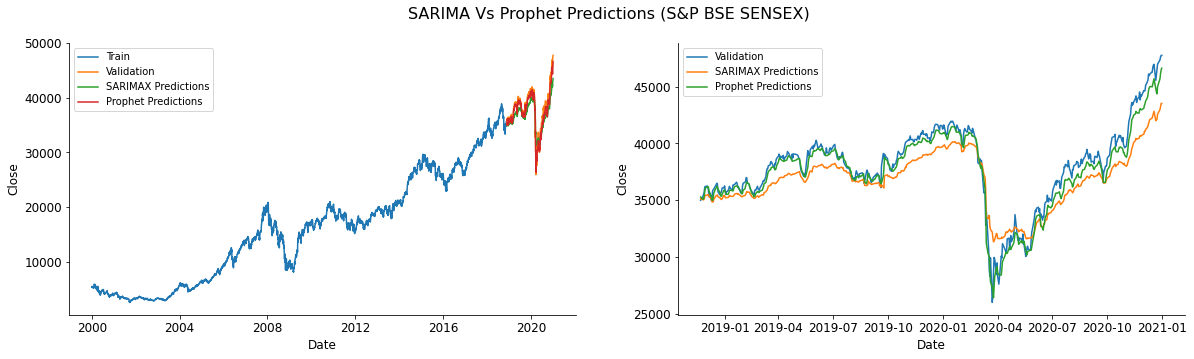

In [ ]:
plot_predictions_matplotlib(sensex_train_data.close, 
                            sensex_validation_data.close, 
                            sensex_predictions, 
                            sensex_prophet_predictions.set_index('ds').yhat, 
                            plot_title = "SARIMA Vs Prophet Predictions (S&P BSE SENSEX)")

In [ ]:
sensex_pred_report_df = compute_error_metrics(sensex_validation_data.close, 
                                              sensex_predictions, 
                                              sensex_prophet_predictions.set_index('ds').yhat)
sensex_pred_report_df

MAE        MedAE           MSE  ...      MSLE  R2-Score      MAPE
SARIMA   1553.134458  1469.234161  3.385244e+06  ...  0.002337  0.731307  4.034418
Prophet   611.322339   489.890230  5.997490e+05  ...  0.000440  0.952397  1.609821

[2 rows x 7 columns]

## S&P-500 Analysis & Forecasting

In [ ]:
s_and_p_500_df = pd.read_csv(S_P_500_DATA_PATH, parse_dates = ['Date'])
s_and_p_500_df.columns = [col_name.lower() for col_name in s_and_p_500_df.columns]
s_and_p_500_df = s_and_p_500_df.loc[s_and_p_500_df.date >= '2000'].drop('volume', axis = 1).reset_index(drop = True)
s_and_p_500_df['first_diff'] = s_and_p_500_df.close.diff().fillna(0.0)
s_and_p_500_df['pc_change'] = (100 * s_and_p_500_df.close.pct_change()).fillna(0.0)
s_and_p_500_df['year'] = s_and_p_500_df.date.dt.year.astype(np.int32)
s_and_p_500_df['month'] = s_and_p_500_df.date.dt.month.astype(np.int8)
s_and_p_500_df['day'] = s_and_p_500_df.date.dt.day.astype(np.int8)
s_and_p_500_df['day_of_week'] = s_and_p_500_df.date.dt.dayofweek.astype(np.int8)

In [ ]:
lag_features = ['low', 'high']
window_sizes = [3, 7, 30, 50, 100, 200]
for feature in lag_features:
    for window_size in window_sizes:
        s_and_p_500_df[f"{feature}_mean_lag_{window_size}"] = s_and_p_500_df.close.rolling(window_size).mean().astype(np.float32)
        s_and_p_500_df[f"{feature}_std_dev_lag_{window_size}"] = s_and_p_500_df.close.rolling(window_size).std().astype(np.float32)
for efeature in exogenous_features:
    s_and_p_500_df[efeature].fillna(s_and_p_500_df[efeature].mean(), inplace = True)

In [ ]:
s_and_p_500_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5283 entries, 0 to 5282
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5283 non-null   datetime64[ns]
 1   open                  5283 non-null   float64       
 2   high                  5283 non-null   float64       
 3   low                   5283 non-null   float64       
 4   close                 5283 non-null   float64       
 5   adj close             5283 non-null   float64       
 6   first_diff            5283 non-null   float64       
 7   pc_change             5283 non-null   float64       
 8   year                  5283 non-null   int32         
 9   month                 5283 non-null   int8          
 10  day                   5283 non-null   int8          
 11  day_of_week           5283 non-null   int8          
 12  low_mean_lag_3        5283 non-null   float32       
 13  low_std_dev_lag_3 

In [ ]:
s_and_p_500_df.describe().T

count         mean  ...          75%          max
open                  5283.0  1653.094190  ...  2071.285034  3750.010010
high                  5283.0  1662.717494  ...  2079.645020  3756.120117
low                   5283.0  1642.628123  ...  2059.690064  3730.209961
close                 5283.0  1653.271474  ...  2071.239991  3735.360107
adj close             5283.0  1653.271474  ...  2071.239991  3735.360107
first_diff            5283.0     0.430971  ...     8.904968   230.380127
pc_change             5283.0     0.025695  ...     0.581900    11.580037
year                  5283.0  2010.004164  ...  2015.000000  2020.000000
month                 5283.0     6.540413  ...    10.000000    12.000000
day                   5283.0    15.741056  ...    23.000000    31.000000
day_of_week           5283.0     2.021200  ...     3.000000     4.000000
low_mean_lag_3        5283.0  1652.920532  ...  2069.895020  3731.479980
low_std_dev_lag_3     5283.0    11.293748  ...    13.974914   203.755859
low_mean_lag_7        5283.0  1652.224365  ...  2067.348633  3709.955811
low_std_dev_lag_7     5283.0    16.546789  ...    19.869190   217.391602
low_mean_lag_30       5283.0  1648.270508  ...  2065.527466  3665.336914
low_std_dev_lag_30    5283.0    32.283901  ...    36.579313   381.951447
low_mean_lag_50       5283.0  1645.049927  ...  2054.551514  3579.218262
low_std_dev_lag_50    5283.0    41.312191  ...    47.039629   378.526947
low_mean_lag_100      5283.0  1637.339722  ...  2034.216492  3490.044189
low_std_dev_lag_100   5283.0    57.731544  ...    65.339455   314.328430
low_mean_lag_200      5283.0  1623.148804  ...  2030.411621  3227.765137
low_std_dev_lag_200   5283.0    80.778664  ...    88.505070   340.695404
high_mean_lag_3       5283.0  1652.920532  ...  2069.895020  3731.479980
high_std_dev_lag_3    5283.0    11.293748  ...    13.974914   203.755859
high_mean_lag_7       5283.0  1652.224365  ...  2067.348633  3709.955811
high_std_dev_lag_7    5283.0    16.546789  ...    19.869190   217.391602
high_mean_lag_30      5283.0  1648.270508  ...  2065.527466  3665.336914
high_std_dev_lag_30   5283.0    32.283901  ...    36.579313   381.951447
high_mean_lag_50      5283.0  1645.049927  ...  2054.551514  3579.218262
high_std_dev_lag_50   5283.0    41.312191  ...    47.039629   378.526947
high_mean_lag_100     5283.0  1637.339722  ...  2034.216492  3490.044189
high_std_dev_lag_100  5283.0    57.731544  ...    65.339455   314.328430
high_mean_lag_200     5283.0  1623.148804  ...  2030.411621  3227.765137
high_std_dev_lag_200  5283.0    80.778664  ...    88.505070   340.695404

[35 rows x 8 columns]

In [ ]:
s_and_p_500_descriptive_stats_df = compute_descriptive_stats('close', 'pc_change', timeseries_data = s_and_p_500_df)
s_and_p_500_descriptive_stats_df

close                  pc_change
Mean                           1653.27                   0.025695
Median                         1386.95                  0.0593618
Min                             676.53                   -11.9841
Max                            3735.36                      11.58
Std. Dev.                      673.836                    1.25313
Skewness                       1.03217                    -0.1538
Kurtosis                     0.0629593                     10.736
Jarque-Bera   (938.3638667469262, 0.0)  (25339.385213564365, 0.0)
Observations                      5283                       5283

In [ ]:
s_and_p_500_df.head()

date         open  ...  high_mean_lag_200  high_std_dev_lag_200
0 2000-01-03  1469.250000  ...        1623.148804             80.778694
1 2000-01-04  1455.219971  ...        1623.148804             80.778694
2 2000-01-05  1399.420044  ...        1623.148804             80.778694
3 2000-01-06  1402.109985  ...        1623.148804             80.778694
4 2000-01-07  1403.449951  ...        1623.148804             80.778694

[5 rows x 36 columns]

date                    0
open                    0
high                    0
low                     0
close                   0
adj close               0
first_diff              0
pc_change               0
year                    0
month                   0
day                     0
day_of_week             0
low_mean_lag_3          0
low_std_dev_lag_3       0
low_mean_lag_7          0
low_std_dev_lag_7       0
low_mean_lag_30         0
low_std_dev_lag_30      0
low_mean_lag_50         0
low_std_dev_lag_50      0
low_mean_lag_100        0
low_std_dev_lag_100     0
low_mean_lag_200        0
low_std_dev_lag_200     0
high_mean_lag_3         0
high_std_dev_lag_3      0
high_mean_lag_7         0
high_std_dev_lag_7      0
high_mean_lag_30        0
high_std_dev_lag_30     0
high_mean_lag_50        0
high_std_dev_lag_50     0
high_mean_lag_100       0
high_std_dev_lag_100    0
high_mean_lag_200       0
high_std_dev_lag_200    0
dtype: int64
Total number of missing values: 0.


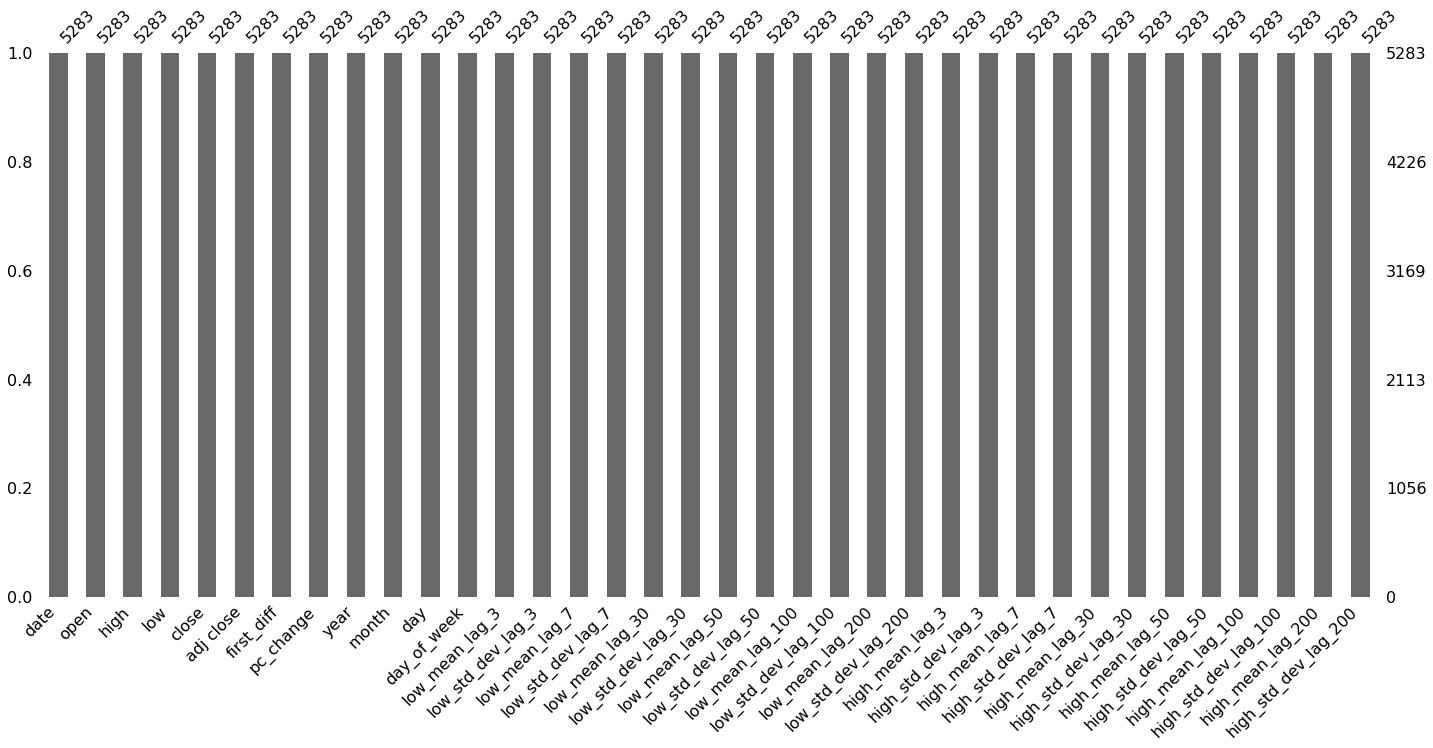

In [ ]:
print(s_and_p_500_df.isnull().sum())
print(f"Total number of missing values: {s_and_p_500_df.isnull().sum().sum()}.")
msno.bar(s_and_p_500_df)

In [ ]:
s_and_p_500_line_plot = px.line(s_and_p_500_df, 
                                x = 'date', 
                                y = 'close', 
                                labels = dict(date = 'Date', close = 'Close'),
                                title = 'S&P-500 (2000-2020)', 
                                template = 'gridon')
s_and_p_500_line_plot.update_xaxes(showspikes = True, rangeselector = rangeselector_properties)
s_and_p_500_line_plot.update_yaxes(showspikes = True)
s_and_p_500_line_plot.show()

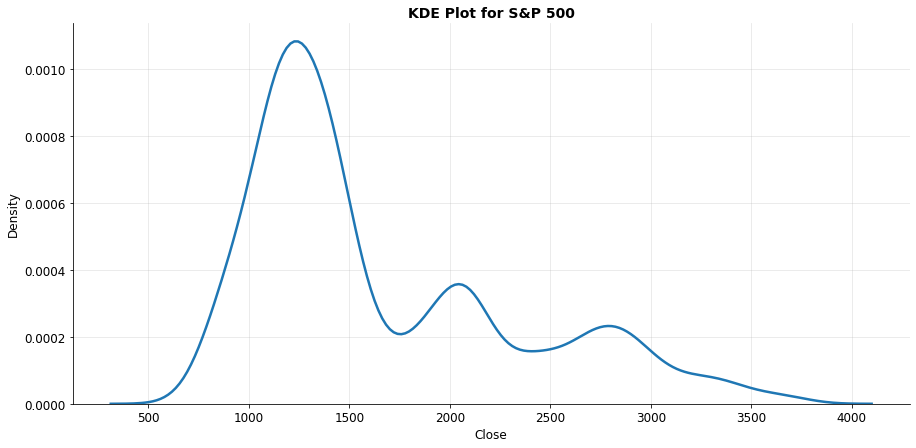

In [ ]:
fig, axis = plt.subplots(figsize = (15, 7))
axis.grid(True, alpha = 0.3)
sns.kdeplot(s_and_p_500_df.close, 
            linewidth = 2.5, 
            ax = axis)
axis.set_title("KDE Plot for S&P 500", 
               fontsize = 14, 
               fontdict = dict(weight = 'bold'))
axis.set_xlabel("Close", fontsize = 12)
axis.set_ylabel("Density", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
sns.despine()

In [ ]:
cboe_vix_df = ipy.get_index_historical_data("S&P 500 VIX", country = 'United States', from_date = '01/01/1990', to_date = '31/12/2020').reset_index().drop(['Volume', 'Currency'], axis = 1)
cboe_vix_df.columns = [col_name.lower() for col_name in cboe_vix_df.columns]
cboe_vix_df['year'] = cboe_vix_df.date.dt.year.astype(np.int32)
cboe_vix_df['month'] = cboe_vix_df.date.dt.month.astype(np.int8)

In [ ]:
cboe_vix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7812 entries, 0 to 7811
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7812 non-null   datetime64[ns]
 1   open    7812 non-null   float64       
 2   high    7812 non-null   float64       
 3   low     7812 non-null   float64       
 4   close   7812 non-null   float64       
 5   year    7812 non-null   int32         
 6   month   7812 non-null   int8          
dtypes: datetime64[ns](1), float64(4), int32(1), int8(1)
memory usage: 343.4 KB


In [ ]:
cboe_vix_df.head()

date   open   high    low  close  year  month
0 1990-01-03  18.19  18.19  18.19  18.19  1990      1
1 1990-01-04  19.22  19.22  19.22  19.22  1990      1
2 1990-01-05  20.11  20.11  20.11  20.11  1990      1
3 1990-01-08  20.26  20.26  20.26  20.26  1990      1
4 1990-01-09  22.20  22.20  22.20  22.20  1990      1

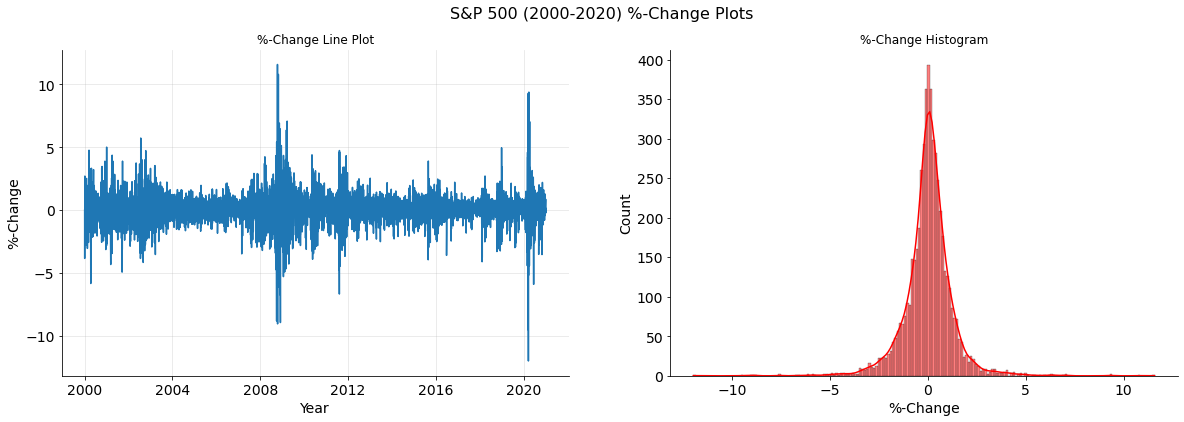

In [ ]:
cboe_vix_plot = go.Figure()
cboe_vix_plot.add_trace(go.Scatter(x = cboe_vix_df.date, y = cboe_vix_df.close, name = 'CBOE-VIX', line = dict(color = 'red')))
cboe_vix_plot.add_trace(go.Scatter(x = cboe_vix_df.date, y = cboe_vix_df.close.rolling(30).mean(), name = 'SMA-30', line = dict(color = 'black')))
cboe_vix_plot.add_trace(go.Box(x = cboe_vix_df.year, y = cboe_vix_df.close, name = 'Yearly Distribution', line = dict(color = 'blue')))
cboe_vix_plot.update_xaxes(showspikes = True, rangeselector = rangeselector_properties)
cboe_vix_plot.update_yaxes(showspikes = True)
cboe_vix_plot.update_layout(title = 'CBOE Volatility Index (VIX)', xaxis_title = 'Date', yaxis_title = 'Close', template = 'gridon')
cboe_vix_plot.show()

s_and_p_500_pct_change_fig, axes = plt.subplots(1, 2, figsize = (20, 6))
s_and_p_500_pct_change_fig.suptitle("S&P 500 (2000-2020) %-Change Plots", 
                                    fontsize = 16, 
                                    fontdict = dict(weight = 'bold'))

sns.lineplot(x = s_and_p_500_df.date, y = s_and_p_500_df.pc_change, ax = axes[0])
axes[0].grid(True, alpha = 0.3)
axes[0].set_title("%-Change Line Plot", fontsize = 12)
axes[0].set_xlabel("Year", fontsize = 14)
axes[0].set_ylabel("%-Change", fontsize = 14)
axes[0].tick_params(which = 'major', labelsize = 14)

sns.histplot(x = s_and_p_500_df.pc_change, kde = True, color = 'red', ax = axes[1])
axes[1].set_title("%-Change Histogram", fontsize = 12)
axes[1].set_xlabel("%-Change", fontsize = 14)
axes[1].set_ylabel("Count", fontsize = 14)
axes[1].tick_params(which = 'major', labelsize = 14)
sns.despine()

In [ ]:
s_and_p_500_subplot = make_subplots()
for window_size, legend_name in zip((30, 50, 100, 200), ('SMA-30', 'SMA-50', 'SMA-100', 'SMA-200')):
    s_and_p_500_subplot.add_trace(go.Scatter(x = s_and_p_500_df.date, 
                                             y = s_and_p_500_df.close.rolling(window_size).mean(), name = legend_name,
                                            visible = 'legendonly' if legend_name != 'SMA-30' else None), 1, 1)
s_and_p_500_subplot.add_trace(go.Box(x = s_and_p_500_df.year, y = s_and_p_500_df.close, name = 'Yearly-Distribution'), 1, 1)
s_and_p_500_subplot.update_layout(title = 'S&P-500 (2000-2020)', xaxis_title = 'Date', yaxis_title = 'Close', template = 'gridon')
s_and_p_500_subplot.update_xaxes(showspikes = True)
s_and_p_500_subplot.show()

### **Augemented Dickey Fuller (ADF) Test To Check Stationarity of the S&P-500 Time Series Data**

* Before applying any forecasting technique we need to check the staionarity of the given time series data. For checking the stationarity we are going to use Augmented Dickey Fuller (ADF) Test which is one of unit root test mostly used to check the stationarity of the time series.
* ADF is statistical test i.e. we will have Null Hypothesis ($H_{0}$) and Alternative Hypothesis ($H_{A}$) and according to test-statistic or p-value we either reject $H_{0}$ or fail to reject $H_{0}$.  

**The Hypothesis are as follows:**
* $H_{0}$: There exist a unit root i.e. $\alpha = 1$ for the given time series hence the time series is non-stationary i.e. it has time-dependent structure.
* $H_{A}$: There doesn't exist unit root i.e. $\alpha \neq 1$ for the given time series hence the given time series is stationary i.e. it doesn't have a time-dependent structure.

#### **Result of ADF Test:**
* As $p-value$ obtained i.e. $0.99795 > 0.05 (\alpha) \implies$ we fail to reject $H_{0}$.
* Also if we compare our Test Statistic i.e. $1.631761$ obtained, with $1\% \; (-3.430631)$, $5\% \; (-2.861664)$ and $10\% \; (-2.566836)$ significance level ($\alpha$) critical values we infer that:
Test-Statistic $>$ $1\%$, $5\%$ and $10\%$ significance level ($\alpha$) critical values $\implies$ we fail to reject $H_{0}$.


#### **Conclusions**
* <em>The given time series data i.e. S&P-500 is not stationary as we failed to reject $H_{0}$.</em>

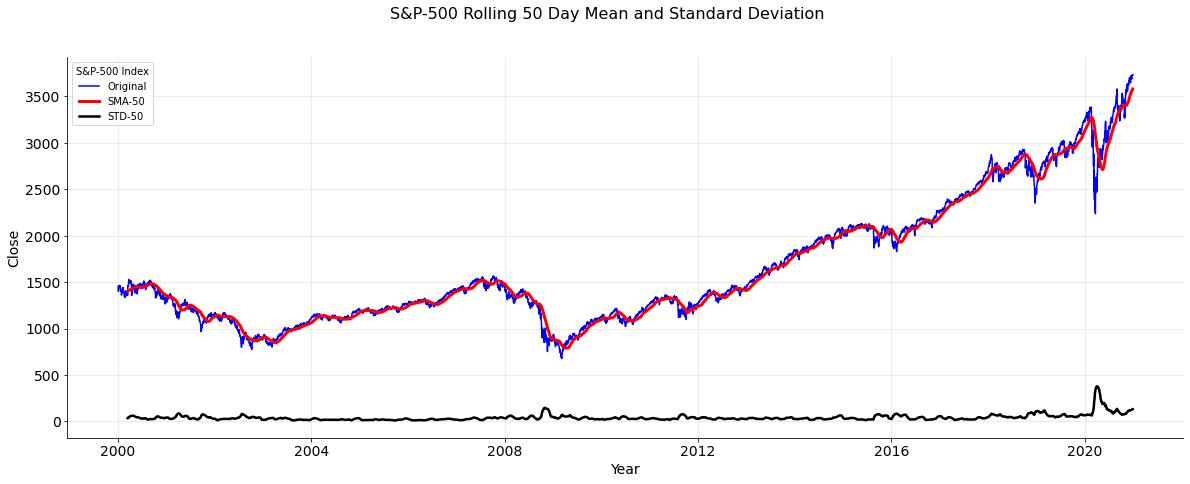

In [ ]:
s_and_p_500_adf_df = perform_stationarity_test(s_and_p_500_df,
                                        feature_name = 'close',
                                        plot_title = 'S&P-500 Rolling 50 Day Mean and Standard Deviation',
                                        legend_title = 'S&P-500 Index')

In [ ]:
s_and_p_500_adf_df

t-statistic  p-value  ...  Critical-Value (5%)  Critical-Value (10%)
0     1.631761  0.99795  ...             -2.86209             -2.567063

[1 rows x 6 columns]

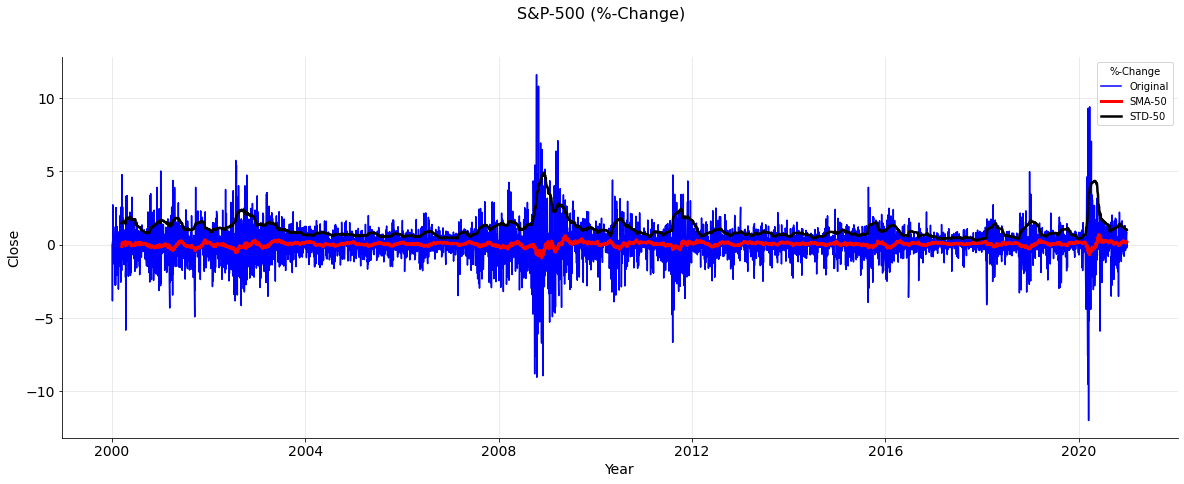

In [ ]:
s_and_p_500_adf_pc_change_df = perform_stationarity_test(s_and_p_500_df, 
                                                         feature_name = 'pc_change',
                                                         plot_title = 'S&P-500 (%-Change)', 
                                                         legend_title = '%-Change')

#### **Result of ADF Test on the %-Change in the Close value of S&P-500:**
* As $p-value$ obtained i.e.  $1.094051 \times 10^{-25} << 0.05 (\alpha)\implies$ we have enough evidence to reject the $H_{0}$.
* Also if we compare our Test Statistic i.e. $-13.74109$ with $1\%\;(-3.431032)$ and $5\% \;(-2.861841)$ and $10\% \; (-2.56693)$ critical values we infer that:
Test-Statistic $<$ $1\%$ and $5\%$ and $10\%$ significance level critical values $\implies$ we have enough evidence to reject the $H_{0}$.


#### **Conclusions:**
* <em>The given time series data i.e. %-Change in Closing Value of S&P BSE SENSEX is stationary as we reject $H_{0}$.</em>

In [ ]:
s_and_p_500_adf_pc_change_df

t-statistic       p-value  ...  Critical-Value (5%)  Critical-Value (10%)
0    -13.74109  1.094051e-25  ...            -2.862091             -2.567063

[1 rows x 6 columns]

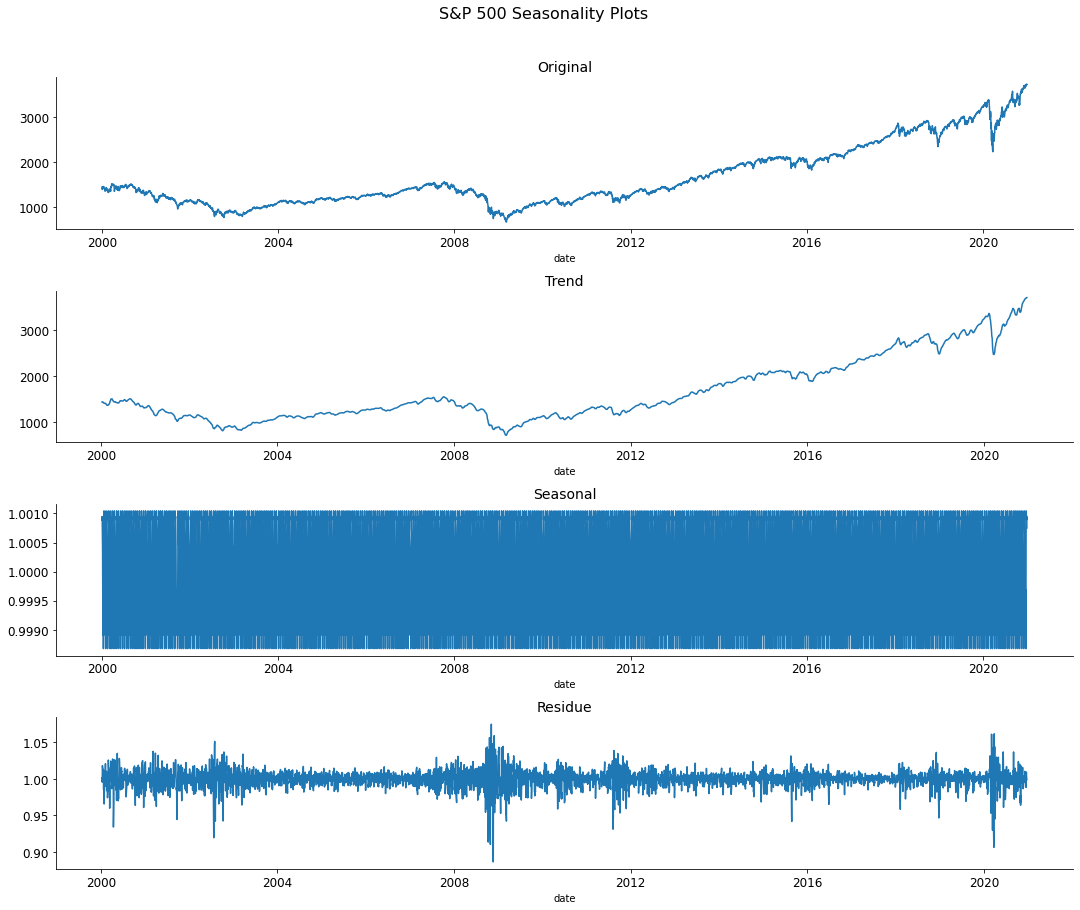

In [ ]:
separate_trend_seasonal(s_and_p_500_df.set_index('date'), 'close', 
                        plot_title = "S&P 500 Seasonality Plots")

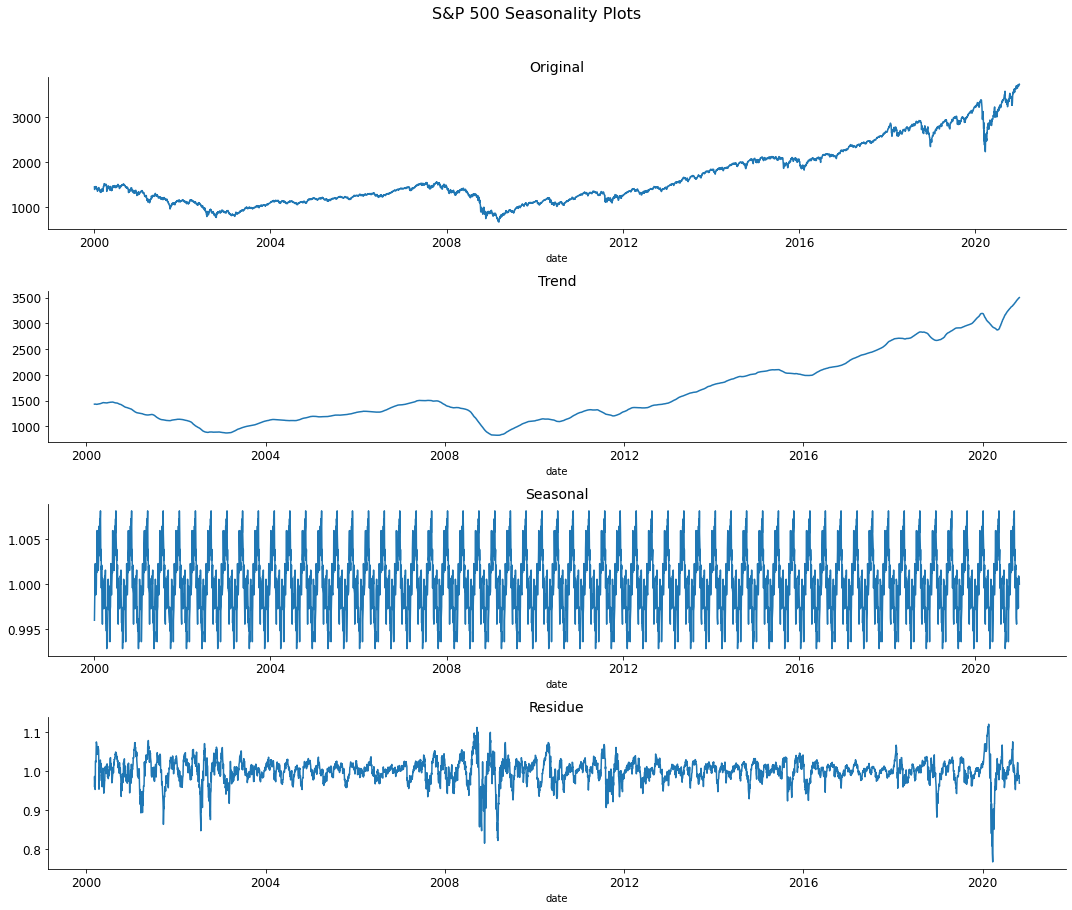

In [ ]:
separate_trend_seasonal(s_and_p_500_df.set_index('date'), 'close',
                        period = 90, 
                        plot_title = "S&P 500 Seasonality Plots")

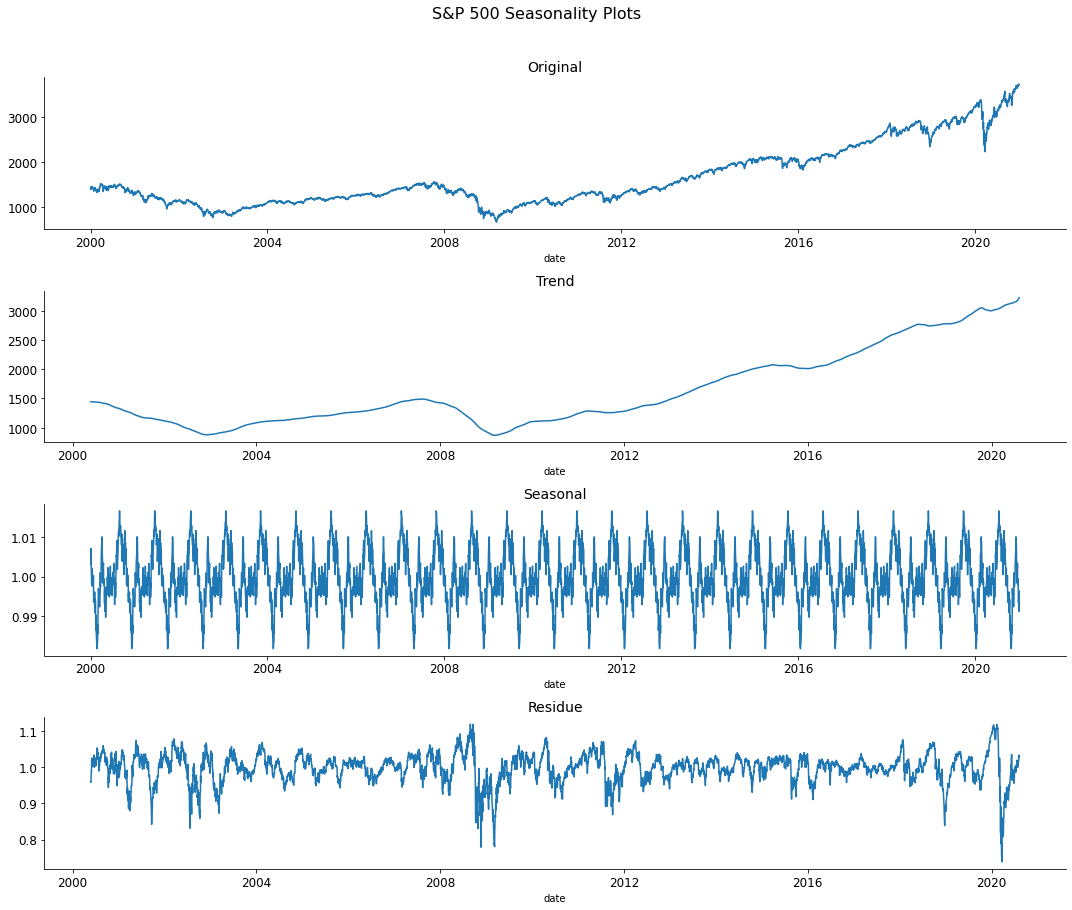

In [ ]:
separate_trend_seasonal(s_and_p_500_df.set_index('date'), 'close',
                        period = 200, 
                        plot_title = "S&P 500 Seasonality Plots")

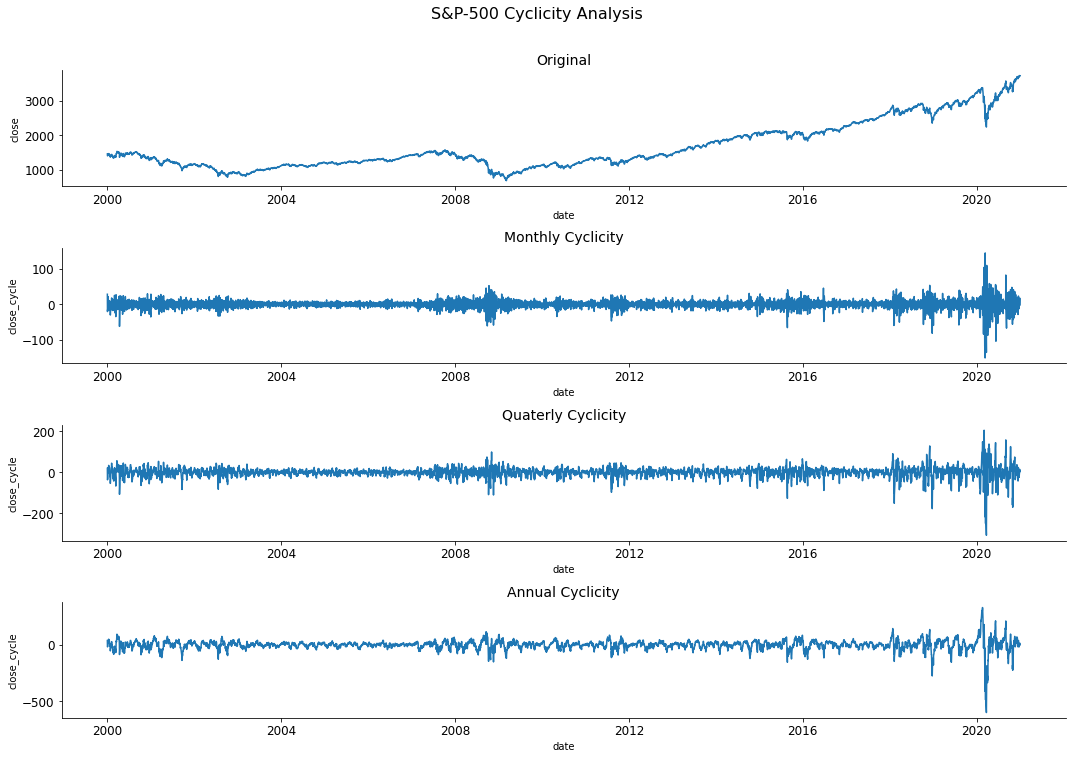

In [ ]:
extract_cyclicity(s_and_p_500_df.set_index('date'), 'close',
                  'S&P-500 Cyclicity Analysis')

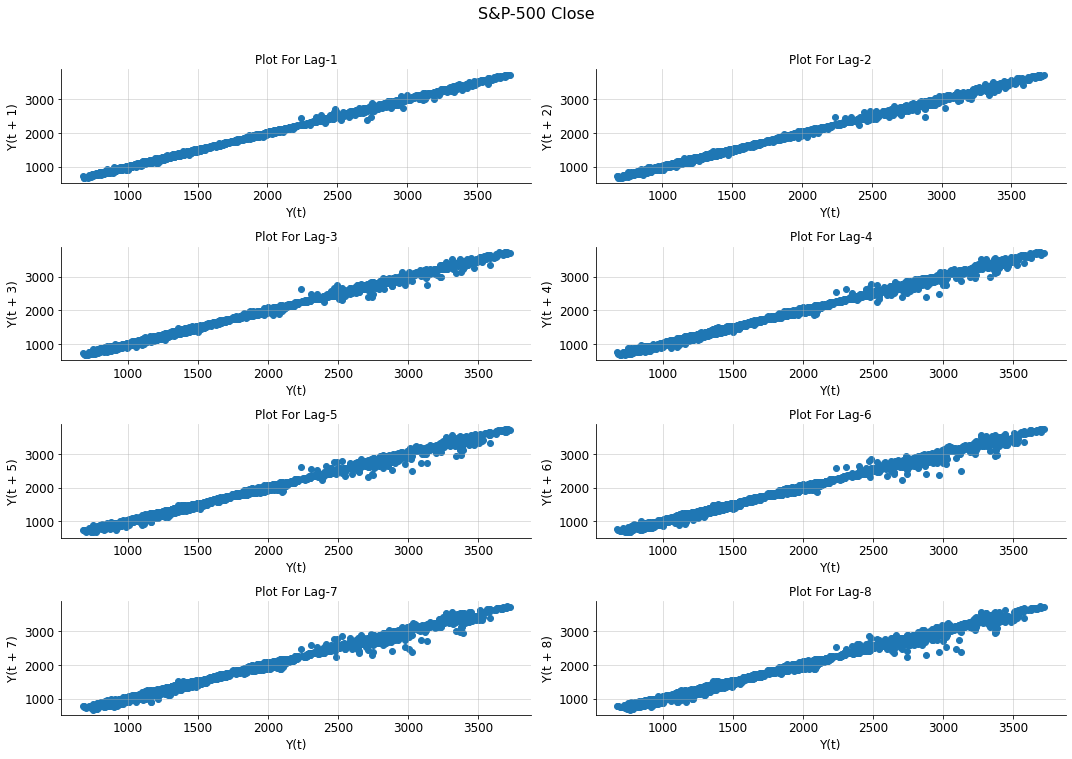

In [ ]:
lag_plots(s_and_p_500_df, 'close', 'S&P-500 Close')

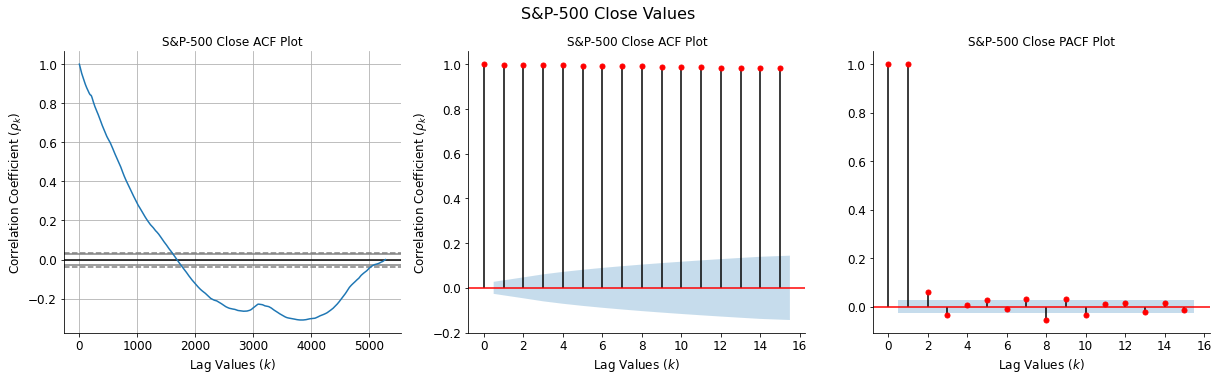

In [ ]:
plot_acf_pacf(s_and_p_500_df.set_index('date'), 'close', 'S&P-500 Close Values',
                 ["S&P-500 Close ACF Plot", "S&P-500 Close PACF Plot"], lags = 15)

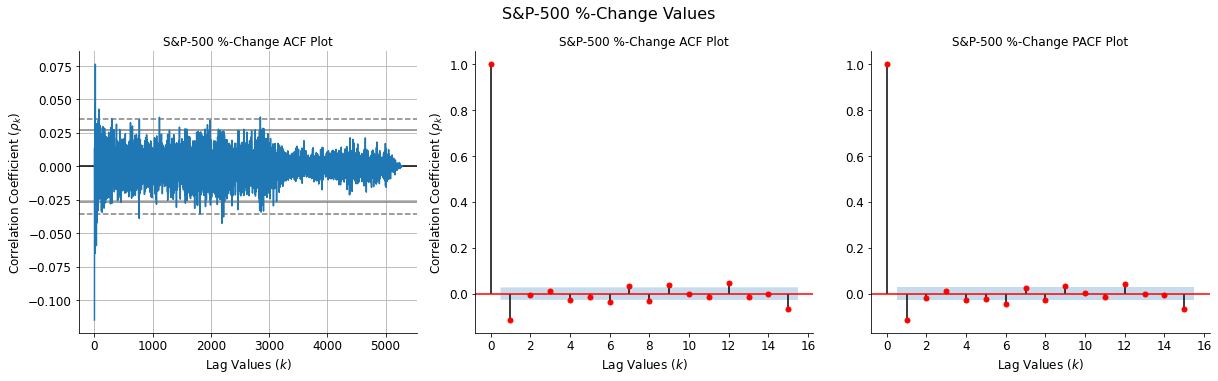

In [ ]:
plot_acf_pacf(s_and_p_500_df.set_index('date'), 'pc_change', 'S&P-500 %-Change Values',
                ['S&P-500 %-Change ACF Plot', 'S&P-500 %-Change PACF Plot'], lags = 15)

In [ ]:
%%time
s_and_p_500_train_data, s_and_p_500_validation_data, s_and_p_500_predictions, s_and_p_500_arima_model = timeseries_forecast_using_arima(s_and_p_500_df.set_index('date'), 
                                                                                                                        forecast_col_name = 'close', 
                                                                                                                        exog_features = exogenous_features)

%store s_and_p_500_train_data
%store s_and_p_500_validation_data 
%store s_and_p_500_predictions 
%store s_and_p_500_arima_model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=94.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=38148.431, Time=3.39 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=37982.573, Time=37.86 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=74.81 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=38146.500, Time=10.95 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=37980.907, Time=14.02 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=37982.527, Time=34.14 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=37979.830, Time=70.14 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=37966.387, Time=101.76 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=37968.068, Time=64.63 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=37966.804, Time=108.45 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=37965.795, Time=108.62 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=37967.801, Time=58.29 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=38134.564, Time=76.14 sec
 ARIMA(2,1,0)(1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Stored 's_and_p_500_train_data' (DataFrame)
Stored 's_and_p_500_validation_data' (DataFrame)
Stored 's_and_p_500_predictions' (Series)
Stored 's_and_p_500_arima_model' (ARIMA)
CPU times: user 1h 33min 53s, sys: 1h 45min 25s, total: 3h 19min 19s
Wall time: 1h 41min 46s


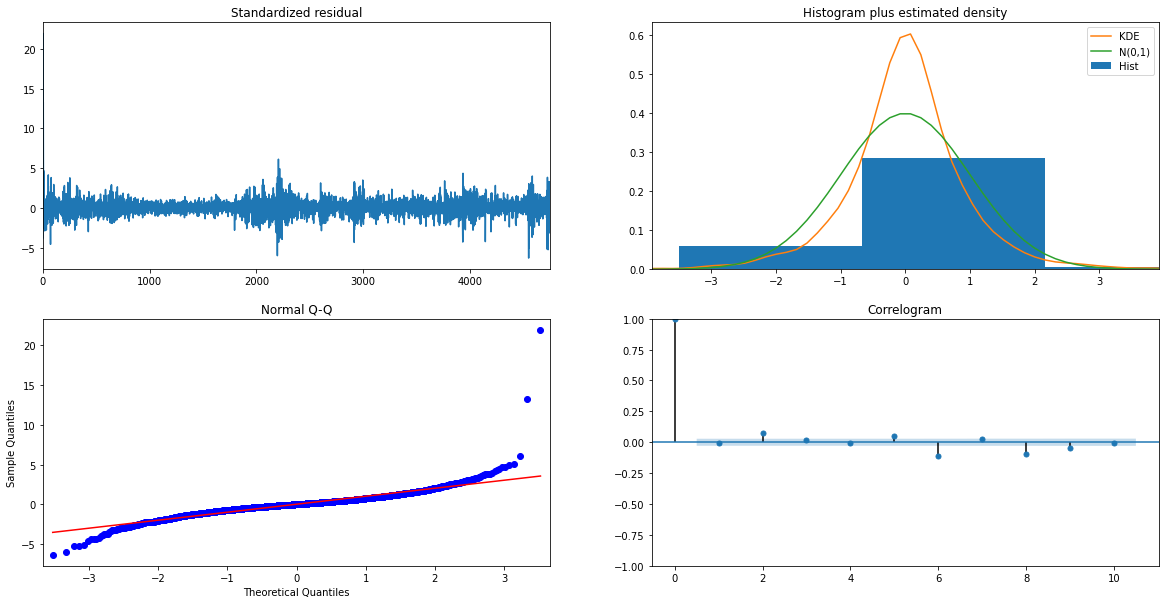

In [ ]:
s_and_p_500_arima_diagnostic_plot = s_and_p_500_arima_model.plot_diagnostics(figsize = (20, 10))

In [ ]:
s_and_p_500_arima_summary = s_and_p_500_arima_model.summary()
s_and_p_500_arima_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4754
Model:             SARIMAX(5, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -17816.630
Date:                           Wed, 26 May 2021   AIC                          35701.260
Time:                                   13:30:19   BIC                          35921.122
Sample:                                        0   HQIC                         35778.516
                                          - 4754                                         
Covariance Type:                             opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
high_mean_lag_3          0.6920      0.005    144.878      0.000       0.683       0.701
high_std_dev_lag_3      -0.0418      0.009     -4.738      0.000      -0.059      -0.024
high_mean_lag_7         -0.2009      0.005    -44.374      0.000      -0.210      -0.192
high_std_dev_lag_7       0.0050      0.009      0.560      0.576      -0.013       0.023
high_mean_lag_30         0.0053      0.002      2.211      0.027       0.001       0.010
high_std_dev_lag_30     -0.0012      0.005     -0.257      0.797      -0.011       0.008
high_mean_lag_50         0.0003      0.002      0.119      0.905      -0.004       0.004
high_std_dev_lag_50      0.0025      0.004      0.581      0.561      -0.006       0.011
high_mean_lag_100        0.0021      0.002      1.111      0.266      -0.002       0.006
high_std_dev_lag_100    -0.0003      0.003     -0.084      0.933      -0.007       0.006
high_mean_lag_200        0.0003      0.002      0.176      0.860      -0.003       0.003
high_std_dev_lag_200    -0.0007      0.003     -0.254      0.800      -0.006       0.004
low_mean_lag_3           0.6920      0.005    144.878      0.000       0.683       0.701
low_std_dev_lag_3       -0.0418      0.009     -4.738      0.000      -0.059      -0.024
low_mean_lag_7          -0.2009      0.005    -44.374      0.000      -0.210      -0.192
low_std_dev_lag_7        0.0050      0.009      0.560      0.576      -0.013       0.023
low_mean_lag_30          0.0053      0.002      2.211      0.027       0.001       0.010
low_std_dev_lag_30      -0.0012      0.005     -0.257      0.797      -0.011       0.008
low_mean_lag_50          0.0003      0.002      0.119      0.905      -0.004       0.004
low_std_dev_lag_50       0.0025      0.004      0.581      0.561      -0.006       0.011
low_mean_lag_100         0.0021      0.002      1.111      0.266      -0.002       0.006
low_std_dev_lag_100     -0.0003      0.003     -0.084      0.933      -0.007       0.006
low_mean_lag_200         0.0003      0.002      0.176      0.860      -0.003       0.003
low_std_dev_lag_200     -0.0007      0.003     -0.254      0.800      -0.006       0.004
ar.L1                    0.3056      0.009     34.495      0.000       0.288       0.323
ar.L2                   -0.5092      0.008    -65.834      0.000      -0.524      -0.494
ar.L3                    0.0129      0.009      1.367      0.172      -0.006       0.031
ar.L4                   -0.2898      0.009    -32.653      0.000      -0.307      -0.272
ar.L5                   -0.1271      0.012    -10.437      0.000      -0.151      -0.103
ma.L1                   -0.9875      0.011    -91.492      0.000      -1.009      -0.966
ar.S.L7                  0.0100      0.496      0.020      0.984      -0.961       0.981
ar.S.L14                 0.0071      0.088      0.081      0.935      -0.165       0.179
ma.S.L7                 -0.

In [ ]:
plot_predictions(s_and_p_500_train_data, 
                 s_and_p_500_validation_data, 
                 col_name = 'close', 
                 forecast_data = s_and_p_500_predictions, 
                 plot_title = "SARIMA Predictions (S&P-500 Index)")

In [ ]:
s_and_p_500_prophet_model, s_and_p_500_prophet_forecast = timeseries_forecast_using_prophet(s_and_p_500_df, exogenous_features)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


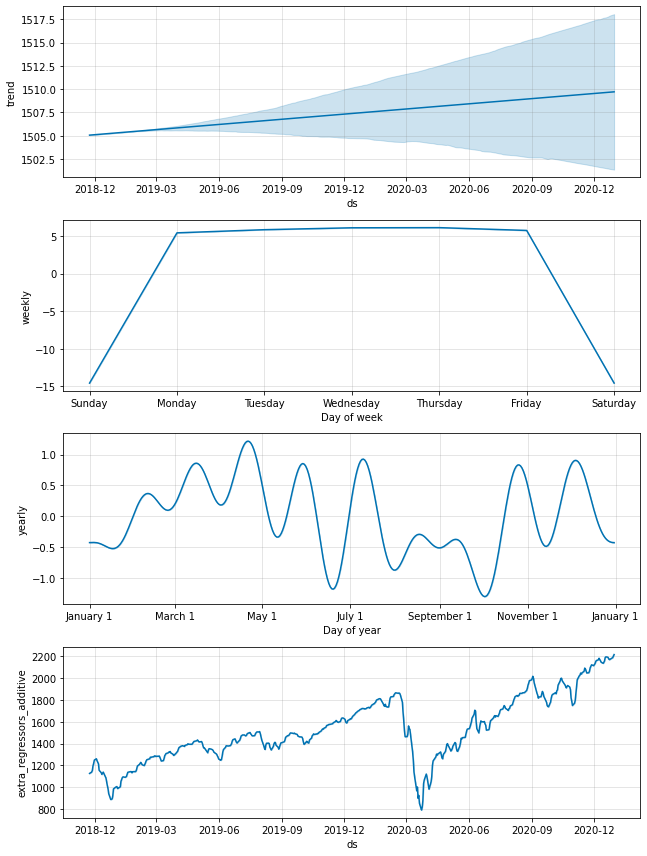

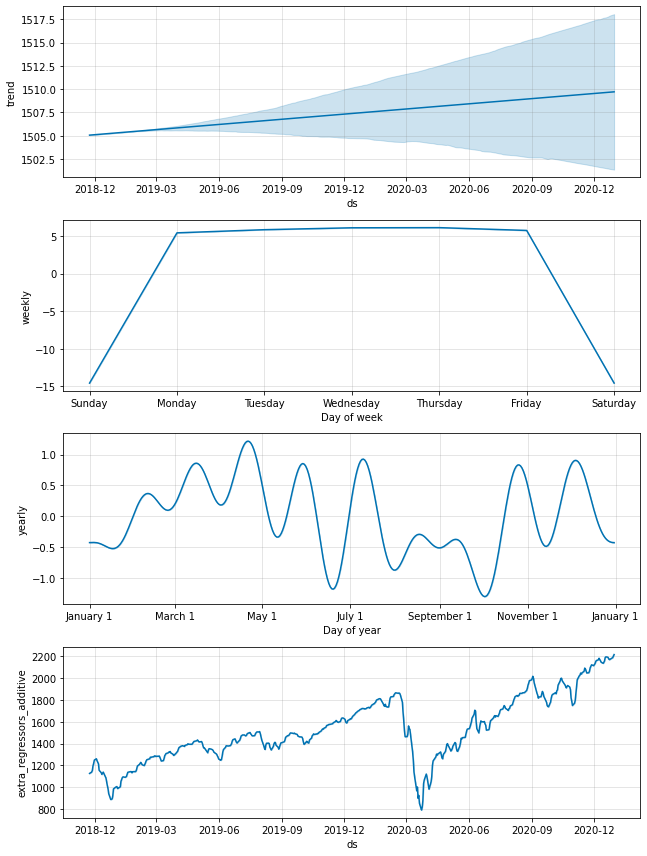

In [ ]:
s_and_p_500_prophet_model.plot_components(s_and_p_500_prophet_forecast)

In [ ]:
plot_predictions(s_and_p_500_train_data, 
                 s_and_p_500_validation_data, 
                 col_name = 'close', 
                 forecast_data = s_and_p_500_prophet_forecast.set_index('ds').yhat, 
                 plot_title = 'Prophet Predictions (S&P-500 Index)')

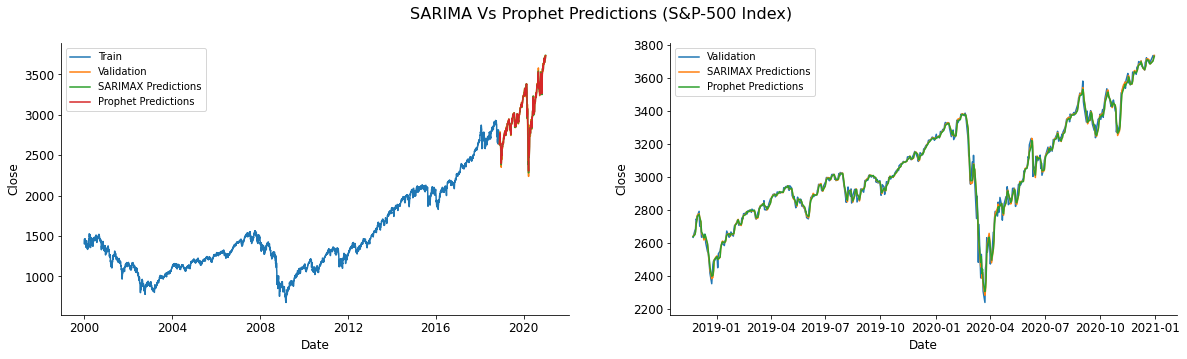

In [ ]:
plot_predictions_matplotlib(s_and_p_500_train_data.close, 
                            s_and_p_500_validation_data.close, 
                            s_and_p_500_predictions, 
                            s_and_p_500_prophet_forecast.set_index('ds').yhat, 
                            plot_title = 'SARIMA Vs Prophet Predictions (S&P-500 Index)')

In [ ]:
s_and_p_pred_report_df = compute_error_metrics(s_and_p_500_validation_data.close, 
                                               s_and_p_500_predictions, 
                                               s_and_p_500_prophet_forecast.set_index('ds').yhat)
s_and_p_pred_report_df

MAE      MedAE         MSE  ...      MSLE  R2-Score      MAPE
SARIMA   18.188209  11.458243  755.415419  ...  0.000094  0.991685  0.616200
Prophet  18.451888  12.117972  770.786803  ...  0.000096  0.991516  0.625178

[2 rows x 7 columns]